In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# 1. Data Preparation
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch Tensor 将像素值从 [0, 255] 映射到 [0.0, 1.0] 的浮点数
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the dataset 𝑥norm=𝑥−𝜇/𝜎标准化为0均值 单位方差
    ])

In [69]:
# Download and load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True,
                               transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False,
                              transform=transform, download=True)

In [70]:
# Create data loaders
# train_loader 每调用一次返回一个新的迭代对象  迭代随机分成的多个batch
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [3]:
# 2. Model Construction
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(28*28, 32)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, 10)     # Hidden layer to output layer
        self.softmax = nn.LogSoftmax(dim=1)  # Use LogSoftmax for numerical stability

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

model = MLP()

In [13]:
#the number of parameters in the shallow network is 32*784+32+10*32+10=25,450
#the number of parameters in the deep network is 30*784+30+28*30+28+26*28+26+10*26+10=25442
#deep network
class DMLP(nn.Module):
    def __init__(self):
        super(DMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(784, 24)
        self.l2 = nn.Linear(24, 64)
        self.l3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)     # Hidden layer to output layer
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)  # Use LogSoftmax for numerical stability

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        x = self.output(x)
        x = self.softmax(x)
        return x

deep_model = DMLP()

In [32]:
# 3. Model Compilation
#它内部会自动对 output 做 log_softmax,然后用 target 的整数索引来选取对应类别的概率
criterion = nn.NLLLoss()  # Negative Log Likelihood Loss (used with LogSoftmax)
#优化器绑定模型已有参数
optimizer = optim.SGD(model.parameters(), lr=0.01)# lr learning rate


In [ ]:
deep_optimizer = optim.SGD(deep_model.parameters(), lr=0.01)# lr learning rate

In [6]:
# 4. Model Training
epochs = 20
train_losses = []
train_accuracy = []

In [10]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0

    for data, target in train_loader:
        optimizer.zero_grad()# 清除旧梯度 上一个batch
        output = model(data)
        loss = criterion(output, target)  # target is not one-hot encoded in PyTorch one-hot用一个长度为类别总数的向量表示每个类别，其中只有一个位置是 1，其余都是 0。 output: logits
        loss.backward()# 反向传播，计算损失对参数的梯度
        optimizer.step()# 更新参数

        epoch_loss += loss.item()
        #沿着第 1 维（即每行）找出最大值的索引,也就是每个样本预测得分最高的类别索引 keepdim保留原来的维度结构
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()#当前训练的正确样本数

    train_losses.append(epoch_loss / len(train_loader))#平均训练损失
    train_accuracy.append(100. * correct / len(train_loader.dataset)) 

    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracy[-1]:.2f}%')

Epoch 1/20, Loss: 0.4708, Accuracy: 87.14%
Epoch 2/20, Loss: 0.2712, Accuracy: 92.18%
Epoch 3/20, Loss: 0.2235, Accuracy: 93.59%
Epoch 4/20, Loss: 0.1916, Accuracy: 94.55%
Epoch 5/20, Loss: 0.1705, Accuracy: 95.12%
Epoch 6/20, Loss: 0.1545, Accuracy: 95.61%
Epoch 7/20, Loss: 0.1428, Accuracy: 95.92%
Epoch 8/20, Loss: 0.1330, Accuracy: 96.16%
Epoch 9/20, Loss: 0.1246, Accuracy: 96.43%
Epoch 10/20, Loss: 0.1174, Accuracy: 96.59%
Epoch 11/20, Loss: 0.1117, Accuracy: 96.72%
Epoch 12/20, Loss: 0.1061, Accuracy: 96.92%
Epoch 13/20, Loss: 0.1008, Accuracy: 97.09%
Epoch 14/20, Loss: 0.0962, Accuracy: 97.24%
Epoch 15/20, Loss: 0.0920, Accuracy: 97.31%
Epoch 16/20, Loss: 0.0880, Accuracy: 97.46%
Epoch 17/20, Loss: 0.0846, Accuracy: 97.47%
Epoch 18/20, Loss: 0.0815, Accuracy: 97.65%
Epoch 19/20, Loss: 0.0783, Accuracy: 97.75%
Epoch 20/20, Loss: 0.0756, Accuracy: 97.80%


In [15]:
deep_train_losses = []
deep_train_accuracy = []

In [16]:
for epoch in range(epochs):
    deep_model.train()
    epoch_loss = 0
    correct = 0

    for data, target in train_loader:
        deep_optimizer.zero_grad()# 清除旧梯度 上一个batch
        output = deep_model(data)
        loss = criterion(output, target)  # target is not one-hot encoded in PyTorch one-hot用一个长度为类别总数的向量表示每个类别，其中只有一个位置是 1，其余都是 0。 output: logits
        loss.backward()# 反向传播，计算损失对参数的梯度
        deep_optimizer.step()# 更新参数

        epoch_loss += loss.item()
        #沿着第 1 维（即每行）找出最大值的索引,也就是每个样本预测得分最高的类别索引 keepdim保留原来的维度结构
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()#当前训练的正确样本数

    deep_train_losses.append(epoch_loss / len(train_loader))#平均训练损失
    deep_train_accuracy.append(100. * correct / len(train_loader.dataset))

    print(f'Epoch {epoch+1}/{epochs}, Loss: {deep_train_losses[-1]:.4f}, Accuracy: {deep_train_accuracy[-1]:.2f}%')


Epoch 1/20, Loss: 0.7945, Accuracy: 75.34%
Epoch 2/20, Loss: 0.2793, Accuracy: 91.75%
Epoch 3/20, Loss: 0.2174, Accuracy: 93.59%
Epoch 4/20, Loss: 0.1828, Accuracy: 94.57%
Epoch 5/20, Loss: 0.1607, Accuracy: 95.28%
Epoch 6/20, Loss: 0.1445, Accuracy: 95.68%
Epoch 7/20, Loss: 0.1331, Accuracy: 96.00%
Epoch 8/20, Loss: 0.1227, Accuracy: 96.33%
Epoch 9/20, Loss: 0.1142, Accuracy: 96.59%
Epoch 10/20, Loss: 0.1063, Accuracy: 96.81%
Epoch 11/20, Loss: 0.1004, Accuracy: 97.01%
Epoch 12/20, Loss: 0.0954, Accuracy: 97.22%
Epoch 13/20, Loss: 0.0907, Accuracy: 97.23%
Epoch 14/20, Loss: 0.0862, Accuracy: 97.47%
Epoch 15/20, Loss: 0.0822, Accuracy: 97.53%
Epoch 16/20, Loss: 0.0785, Accuracy: 97.61%
Epoch 17/20, Loss: 0.0750, Accuracy: 97.71%
Epoch 18/20, Loss: 0.0714, Accuracy: 97.79%
Epoch 19/20, Loss: 0.0692, Accuracy: 97.88%
Epoch 20/20, Loss: 0.0657, Accuracy: 98.00%


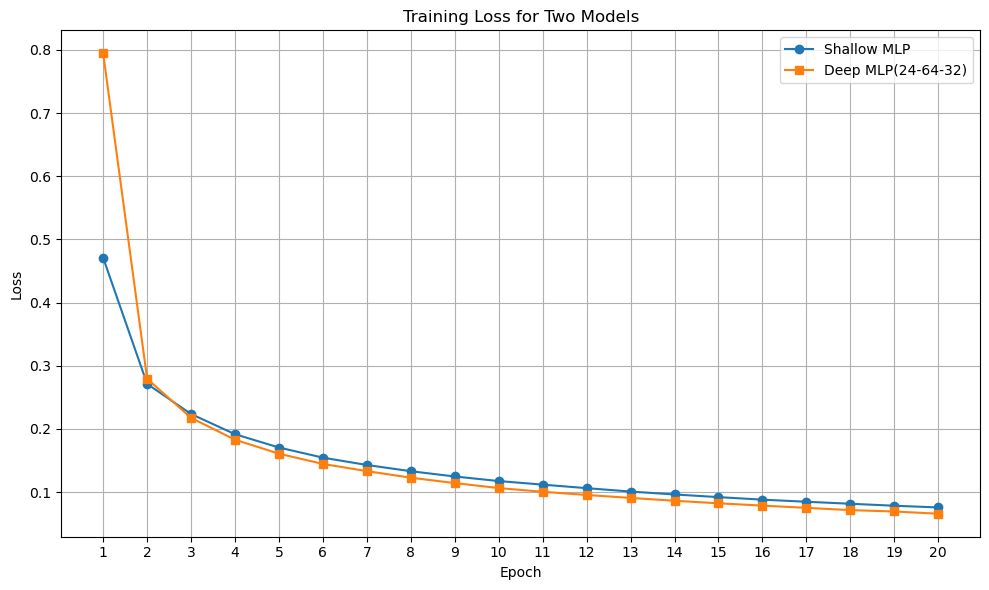

In [17]:
#compare the train process between shallow and deep network
# 创建图形
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, epochs+1)), train_losses, label='Shallow MLP', marker='o')
plt.plot(list(range(1, epochs+1)), deep_train_losses, label='Deep MLP(24-64-32)', marker='s')
plt.xticks(range(1, epochs+1))  # 强制 x 轴显示整数刻度
# 添加标题和标签
plt.title('Training Loss for Two Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 显示图形
plt.show()

In [7]:
import sys
sys.path.append('./ultimate-utils-master/py_src/uutils/torch_uu/dataloaders')
sys.path.append('./ultimate-utils-master/py_src')
from mnist import get_train_valid_loader


F:\Anaconda3\envs\mlp-env\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
F:\Anaconda3\envs\mlp-env\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the

In [63]:
train_loader, val_loader = get_train_valid_loader(
    data_path='./data',
    batch_size=16,
    batch_size_eval=16,
    seed=42,
    augment_train=False,
    val_size=0.2,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [64]:
epochs = 14
train_losses = []
train_accuracy = []
valid_losses = []
valid_accuracy = []
model = MLP()
optimizer = optim.SGD(model.parameters(), lr=0.01)# lr learning rate

In [65]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_loss_valid = 0
    correct = 0
    correct_valid = 0

    for data, target in train_loader:
        optimizer.zero_grad()# 清除旧梯度 上一个batch
        output = model(data)
        loss = criterion(output, target)  # target is not one-hot encoded in PyTorch one-hot用一个长度为类别总数的向量表示每个类别，其中只有一个位置是 1，其余都是 0。 output: logits
        loss.backward()# 反向传播，计算损失对参数的梯度
        optimizer.step()# 更新参数

        epoch_loss += loss.item()
        #沿着第 1 维（即每行）找出最大值的索引,也就是每个样本预测得分最高的类别索引 keepdim保留原来的维度结构
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()#当前训练的正确样本数

    train_losses.append(epoch_loss / len(train_loader))#平均训练损失
    train_accuracy.append(100. * correct / len(train_loader.dataset)) 
    for data, target in val_loader:
        output = model(data)
        loss = criterion(output, target)
        epoch_loss_valid += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct_valid += pred.eq(target.view_as(pred)).sum().item()#当前训练的正确样本数
    valid_losses.append(epoch_loss_valid / len(val_loader))#平均训练损失
    valid_accuracy.append(100. * correct_valid / len(val_loader.dataset)) 

    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracy[-1]:.2f}%')
    print(f'Epoch {epoch+1}/{epochs}, Loss: {valid_losses[-1]:.4f}, Accuracy: {valid_accuracy[-1]:.2f}%')


Epoch 1/14, Loss: 0.4124, Accuracy: 88.60%
Epoch 1/14, Loss: 0.2605, Accuracy: 92.42%
Epoch 2/14, Loss: 0.2346, Accuracy: 93.29%
Epoch 2/14, Loss: 0.2079, Accuracy: 94.15%
Epoch 3/14, Loss: 0.1896, Accuracy: 94.64%
Epoch 3/14, Loss: 0.1811, Accuracy: 94.78%
Epoch 4/14, Loss: 0.1617, Accuracy: 95.42%
Epoch 4/14, Loss: 0.1709, Accuracy: 95.00%
Epoch 5/14, Loss: 0.1417, Accuracy: 95.96%
Epoch 5/14, Loss: 0.1527, Accuracy: 95.59%
Epoch 6/14, Loss: 0.1271, Accuracy: 96.32%
Epoch 6/14, Loss: 0.1389, Accuracy: 96.01%
Epoch 7/14, Loss: 0.1153, Accuracy: 96.68%
Epoch 7/14, Loss: 0.1360, Accuracy: 95.96%
Epoch 8/14, Loss: 0.1060, Accuracy: 96.96%
Epoch 8/14, Loss: 0.1292, Accuracy: 96.18%
Epoch 9/14, Loss: 0.0985, Accuracy: 97.12%
Epoch 9/14, Loss: 0.1235, Accuracy: 96.31%
Epoch 10/14, Loss: 0.0915, Accuracy: 97.32%
Epoch 10/14, Loss: 0.1216, Accuracy: 96.41%
Epoch 11/14, Loss: 0.0851, Accuracy: 97.52%
Epoch 11/14, Loss: 0.1242, Accuracy: 96.18%
Epoch 12/14, Loss: 0.0804, Accuracy: 97.62%
Epoch 

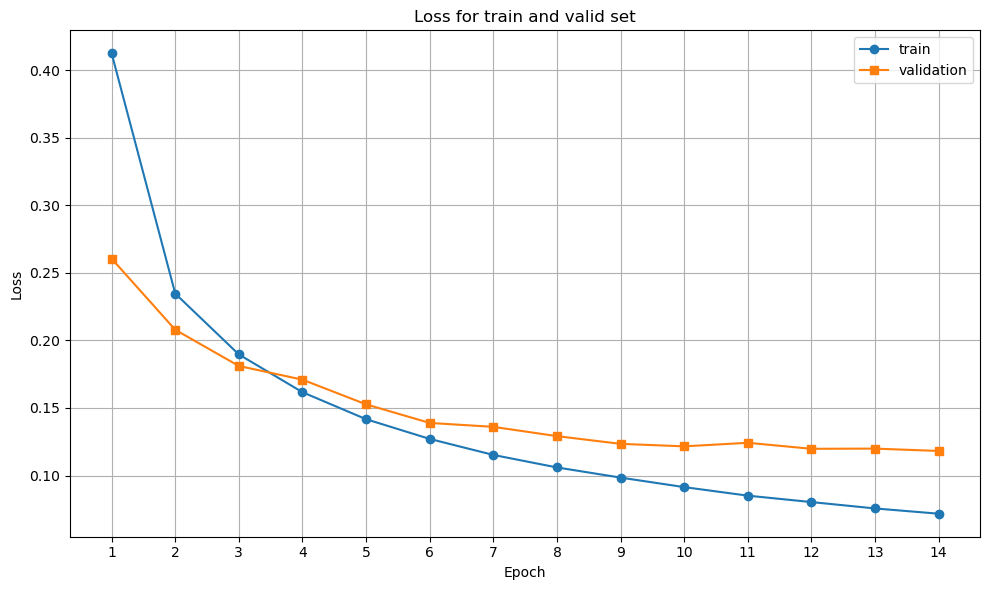

In [66]:
#compare the train process between shallow and deep network
# 创建图形
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, epochs+1)), train_losses, label='train', marker='o')
plt.plot(list(range(1, epochs+1)), valid_losses, label='validation', marker='s')
plt.xticks(range(1, epochs+1))  # 强制 x 轴显示整数刻度
# 添加标题和标签
plt.title('Loss for train and valid set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 显示图形
plt.show()

In [75]:
# 5. Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
model.eval()
test_loss = 0
correct = 0
all_preds = []
all_targets = []
images = []
#with 是 Python 中的上下文管理器（context manager）语法，它的作用是：
#在一段代码块执行前后自动处理资源的初始化和清理工作。
#在这个代码块中，不要追踪梯度计算（no gradient tracking）
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        all_preds.extend(pred.numpy())
        all_targets.extend(target.numpy())
        images.extend(data)

test_loss /= len(test_loader)
test_accuracy = 100. * correct / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
print('confusion_matrix:  \n',confusion_matrix(all_targets,all_preds))

Test Loss: 0.1194, Test Accuracy: 96.48%
confusion_matrix:  
 [[ 966    0    2    2    2    2    3    1    1    1]
 [   0 1119    5    1    0    0    4    1    5    0]
 [   4    3 1005    4    3    1    2    5    4    1]
 [   1    0    4  984    0   10    1    1    6    3]
 [   0    0    3    0  954    0    6    1    3   15]
 [   5    0    2    9    3  844   12    4    9    4]
 [   5    2    1    1    6    9  930    0    4    0]
 [   0   12   15    7    6    1    0  966    2   19]
 [   5    1    7   12    7    5    6    4  922    5]
 [   3    7    3    7   19    1    0    4    7  958]]


In [74]:
print('classification_report:  \n', classification_report(all_targets,all_preds))

classification_report:  
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.95      0.97      0.96       982
           5       0.97      0.95      0.96       892
           6       0.96      0.97      0.97       958
           7       0.98      0.94      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [78]:
#9 4,   7  9,
def show_prediction(index):
    img = images[index].squeeze()  # MNIST 是 [1, 28, 28]
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {all_preds[index]}, True: {all_targets[index]}")
    plt.axis('off')
    plt.show()

Misclassified index 8: Predicted [6], True 5


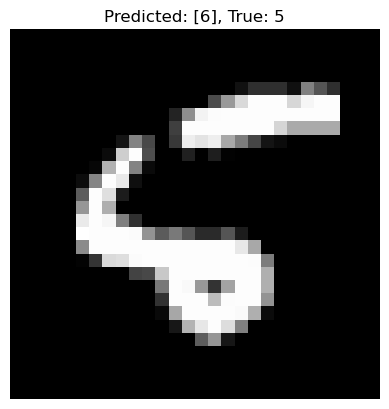

Misclassified index 115: Predicted [9], True 4


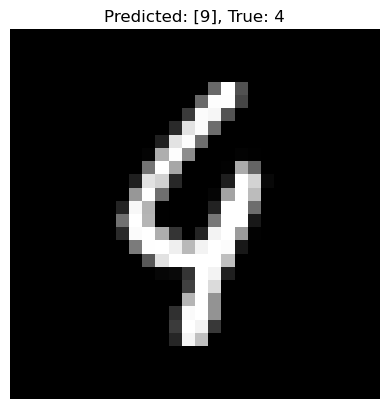

Misclassified index 124: Predicted [4], True 7


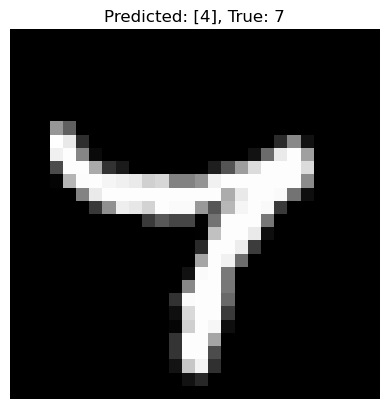

Misclassified index 149: Predicted [4], True 2


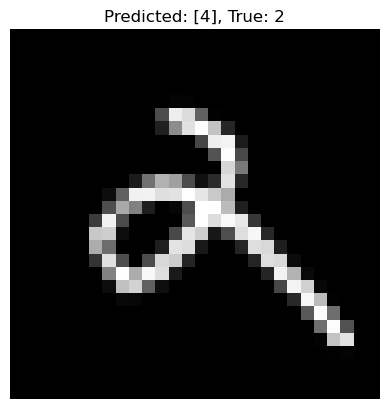

Misclassified index 175: Predicted [1], True 7


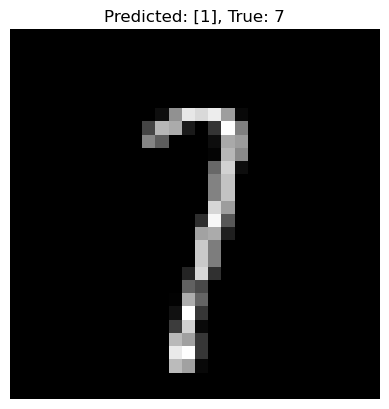

Misclassified index 247: Predicted [6], True 4


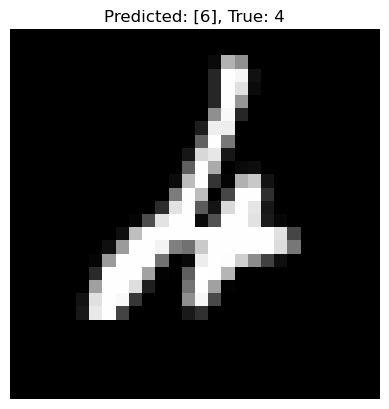

Misclassified index 274: Predicted [3], True 9


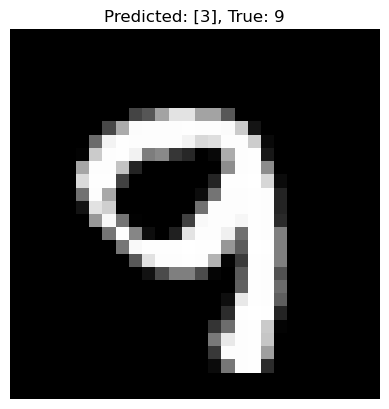

Misclassified index 290: Predicted [4], True 8


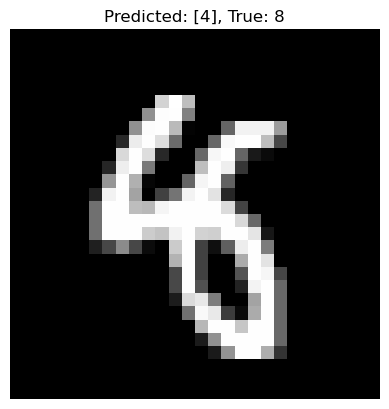

Misclassified index 320: Predicted [1], True 9


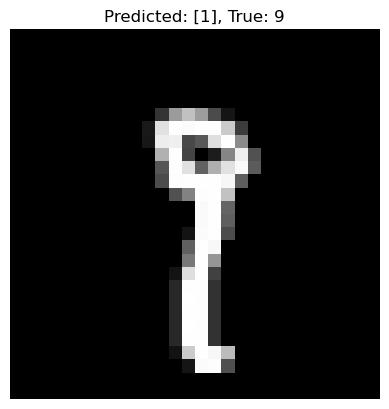

Misclassified index 321: Predicted [7], True 2


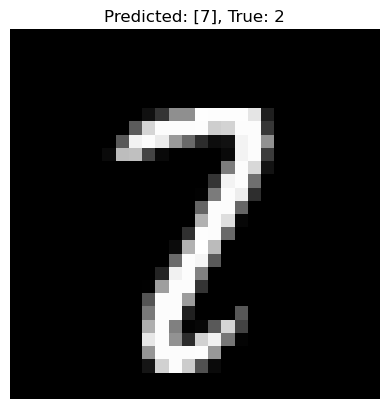

Misclassified index 445: Predicted [0], True 6


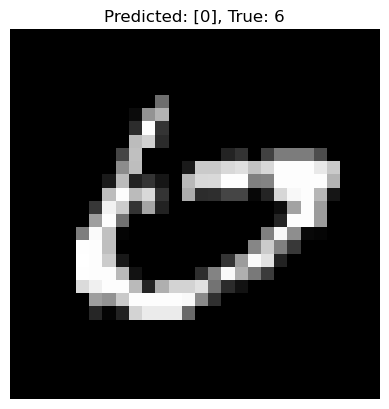

Misclassified index 448: Predicted [8], True 9


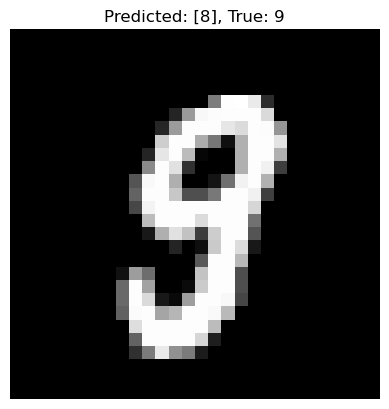

Misclassified index 478: Predicted [8], True 5


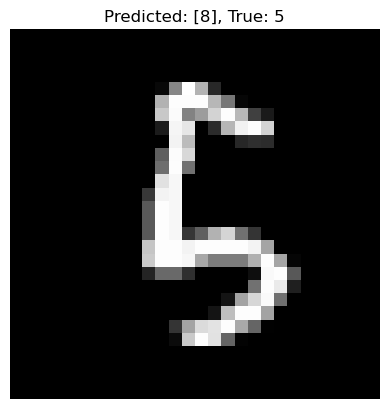

Misclassified index 495: Predicted [0], True 8


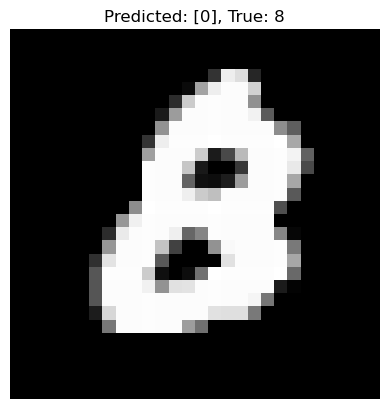

Misclassified index 543: Predicted [2], True 8


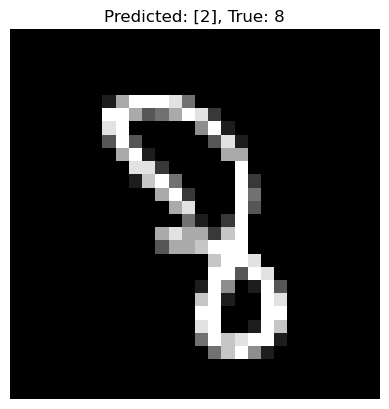

Misclassified index 578: Predicted [2], True 3


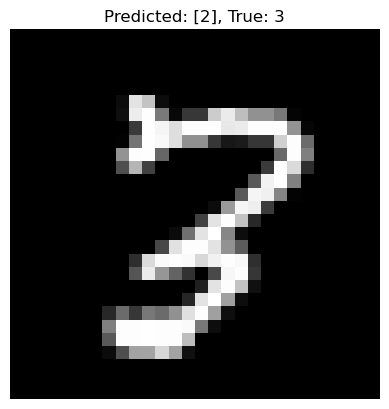

Misclassified index 582: Predicted [2], True 8


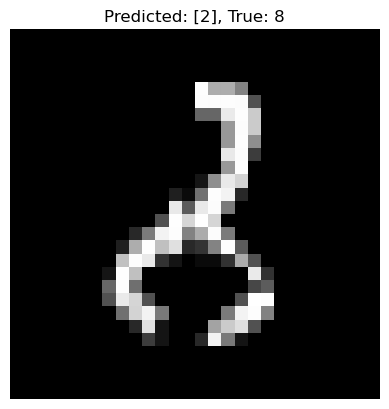

Misclassified index 659: Predicted [1], True 2


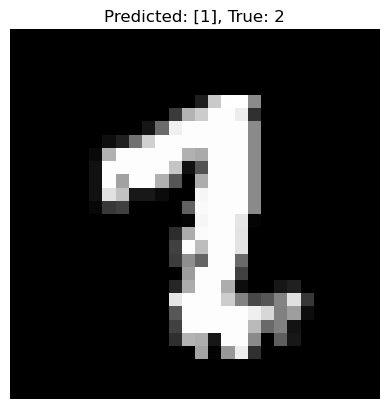

Misclassified index 667: Predicted [2], True 7


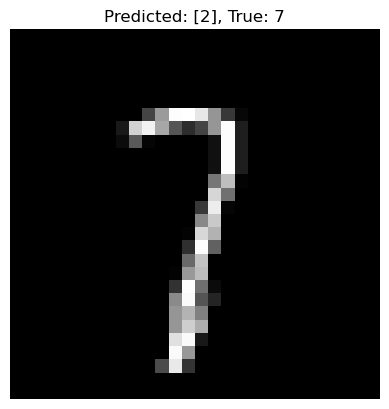

Misclassified index 684: Predicted [2], True 7


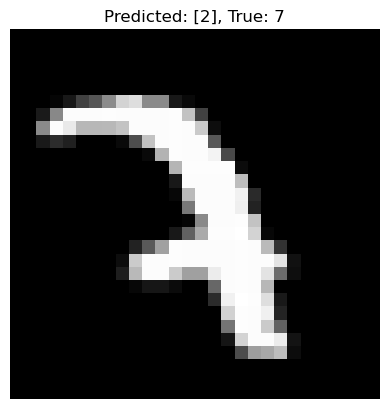

Misclassified index 691: Predicted [4], True 8


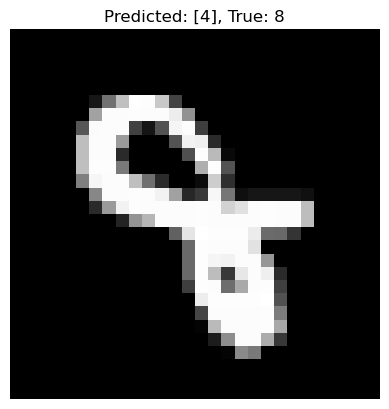

Misclassified index 707: Predicted [9], True 4


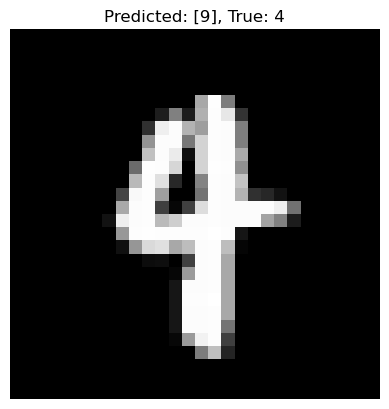

Misclassified index 720: Predicted [8], True 5


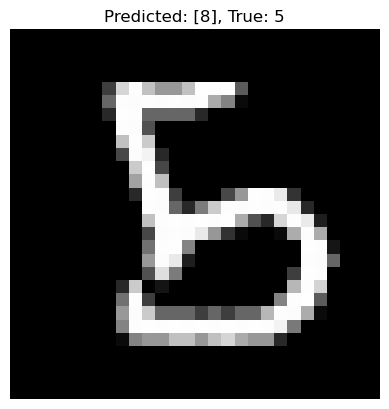

Misclassified index 844: Predicted [7], True 8


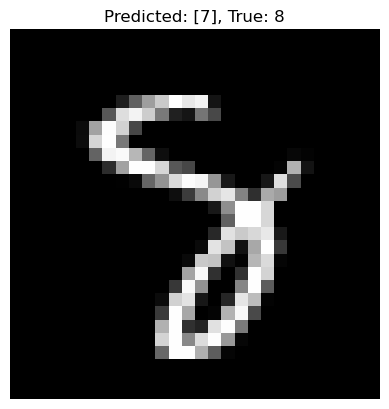

Misclassified index 846: Predicted [9], True 7


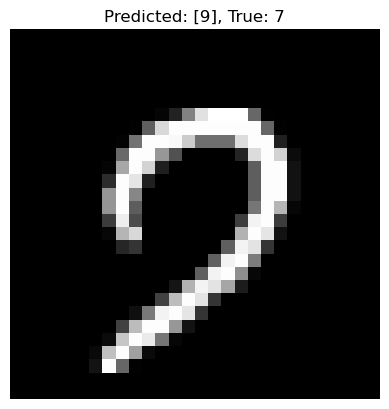

Misclassified index 881: Predicted [9], True 4


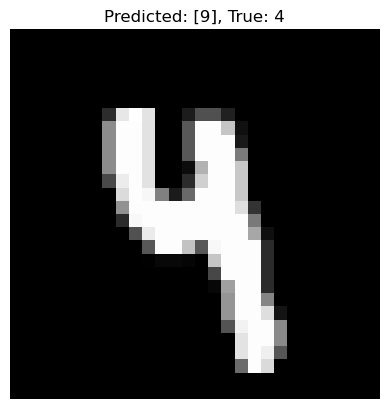

Misclassified index 951: Predicted [4], True 5


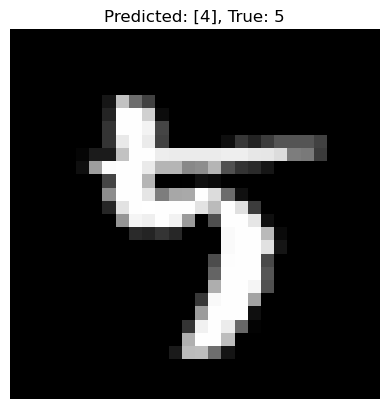

Misclassified index 956: Predicted [2], True 1


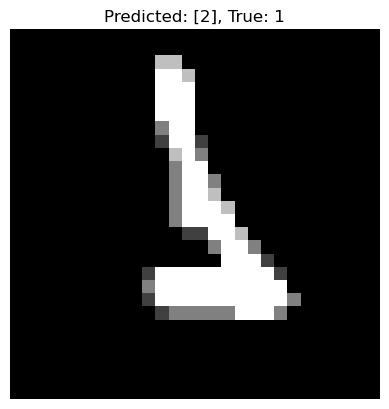

Misclassified index 965: Predicted [0], True 6


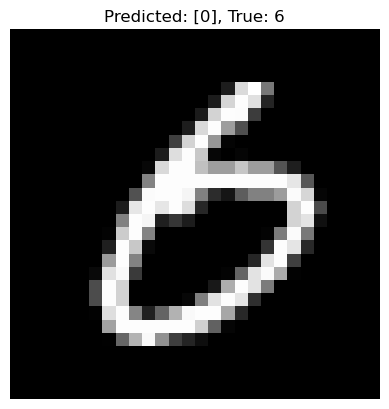

Misclassified index 1014: Predicted [5], True 6


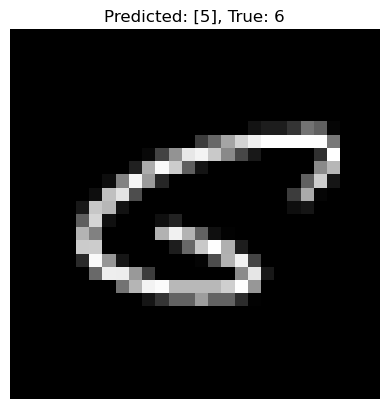

Misclassified index 1032: Predicted [8], True 5


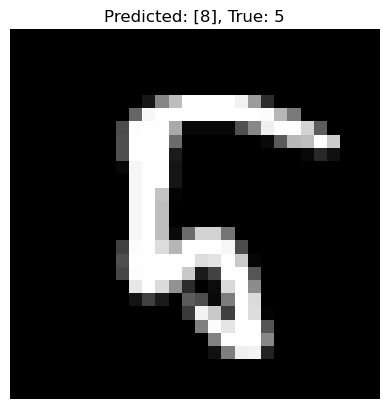

Misclassified index 1039: Predicted [9], True 7


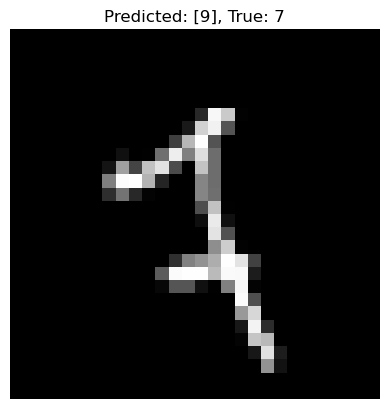

Misclassified index 1044: Predicted [2], True 6


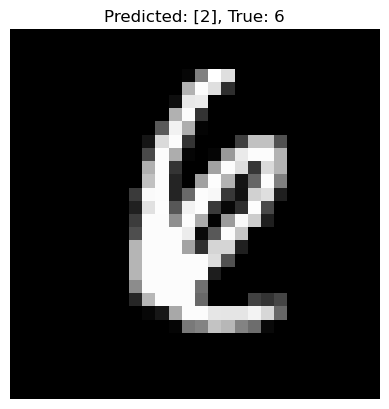

Misclassified index 1055: Predicted [9], True 7


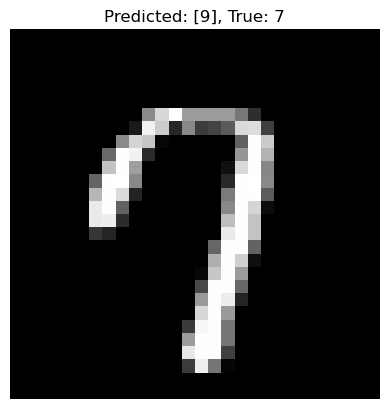

Misclassified index 1096: Predicted [9], True 7


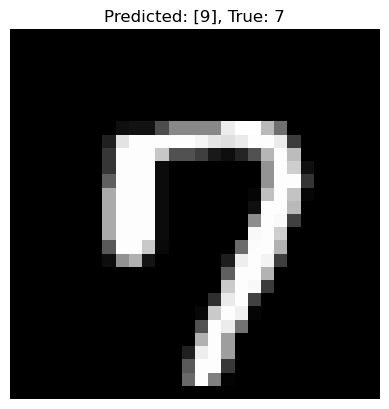

Misclassified index 1107: Predicted [8], True 9


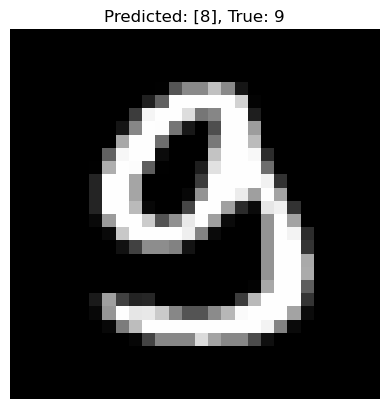

Misclassified index 1125: Predicted [9], True 8


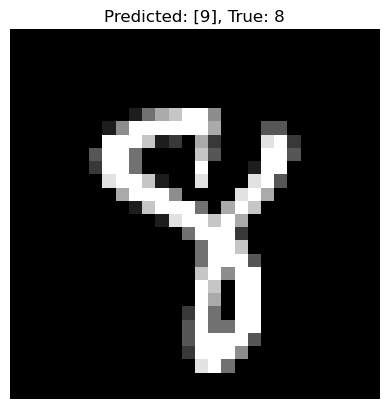

Misclassified index 1178: Predicted [6], True 4


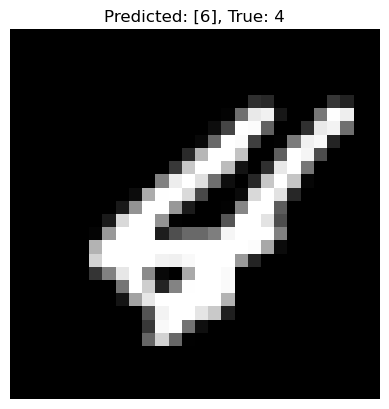

Misclassified index 1182: Predicted [8], True 6


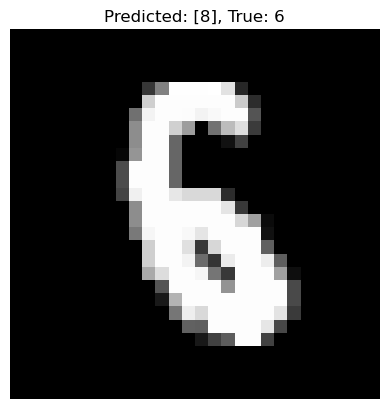

Misclassified index 1192: Predicted [4], True 9


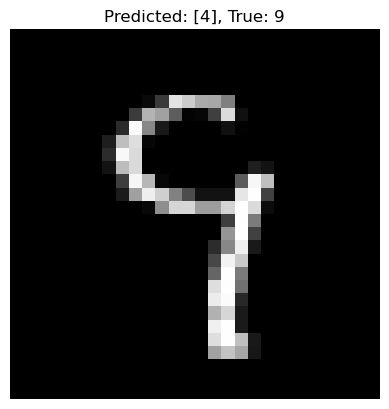

Misclassified index 1198: Predicted [4], True 8


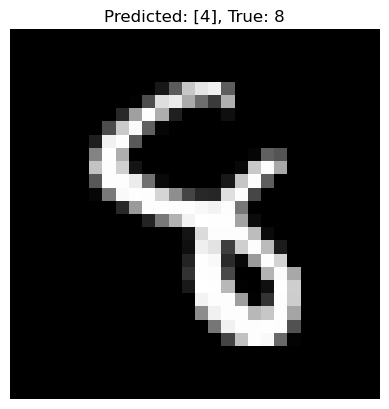

Misclassified index 1216: Predicted [9], True 7


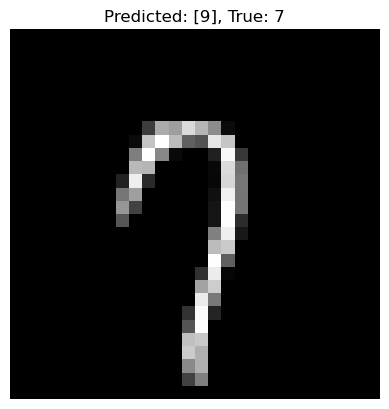

Misclassified index 1226: Predicted [2], True 7


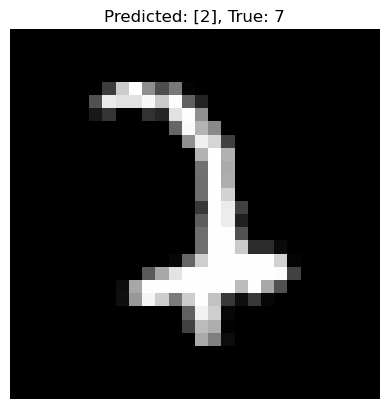

Misclassified index 1232: Predicted [4], True 9


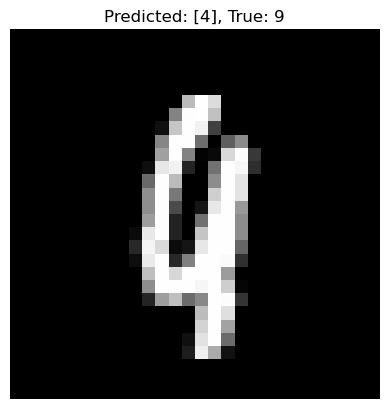

Misclassified index 1242: Predicted [9], True 4


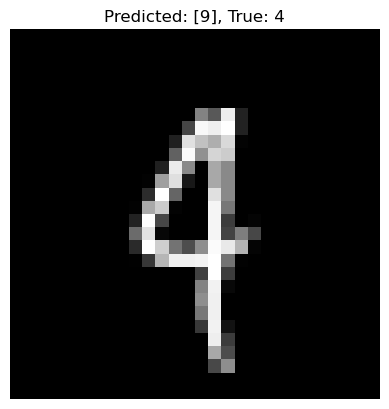

Misclassified index 1243: Predicted [6], True 5


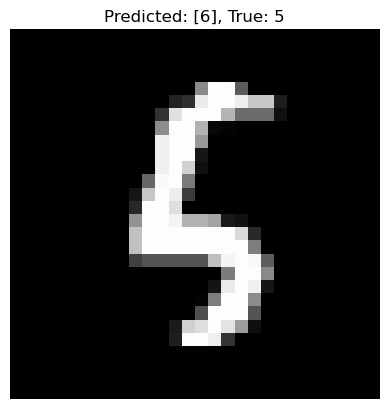

Misclassified index 1247: Predicted [2], True 9


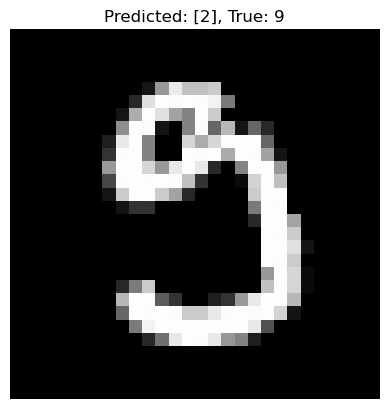

Misclassified index 1251: Predicted [1], True 2


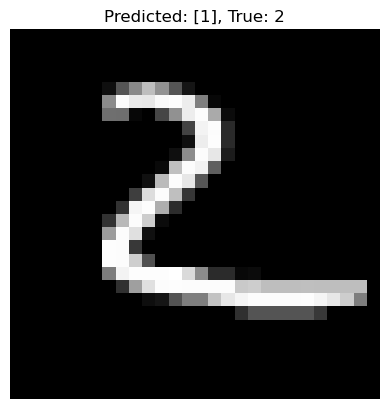

Misclassified index 1260: Predicted [1], True 7


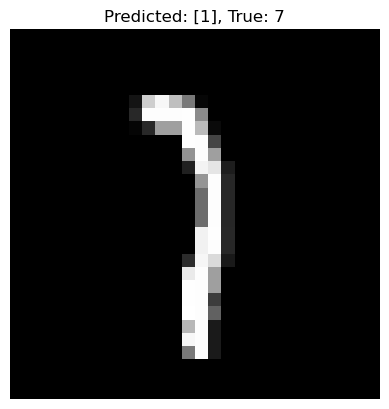

Misclassified index 1272: Predicted [9], True 5


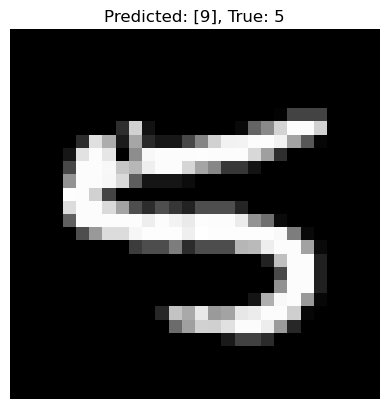

Misclassified index 1283: Predicted [2], True 7


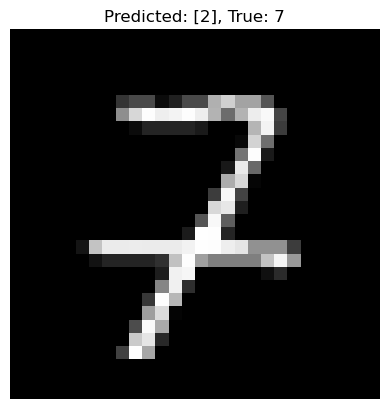

Misclassified index 1299: Predicted [7], True 5


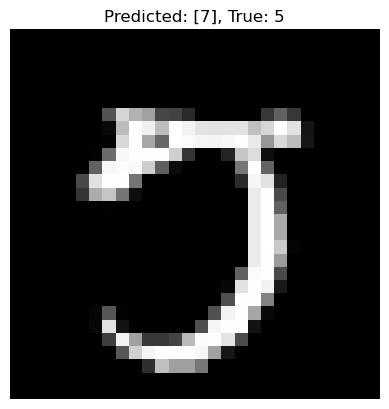

Misclassified index 1319: Predicted [3], True 8


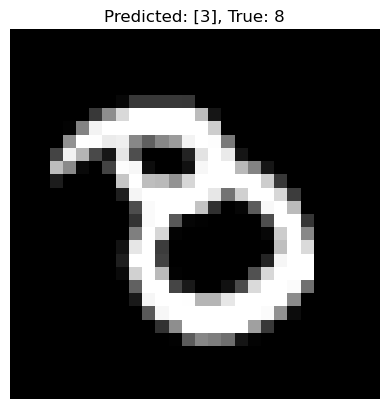

Misclassified index 1326: Predicted [1], True 7


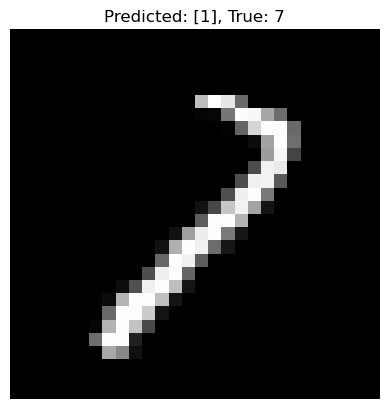

Misclassified index 1328: Predicted [9], True 7


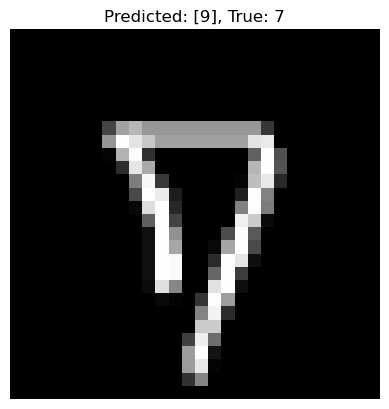

Misclassified index 1337: Predicted [6], True 2


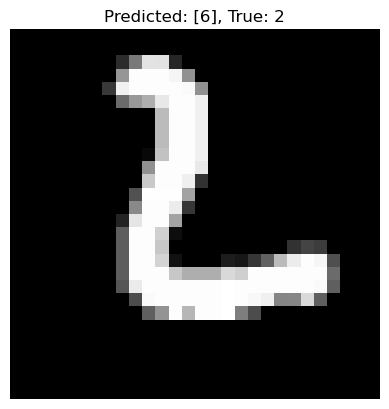

Misclassified index 1364: Predicted [2], True 8


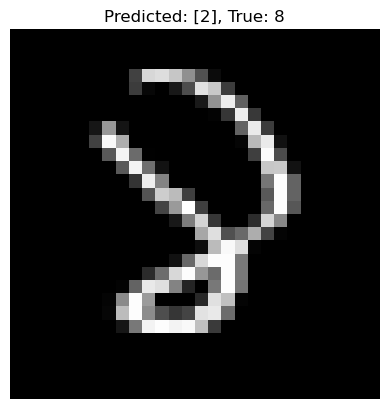

Misclassified index 1378: Predicted [6], True 5


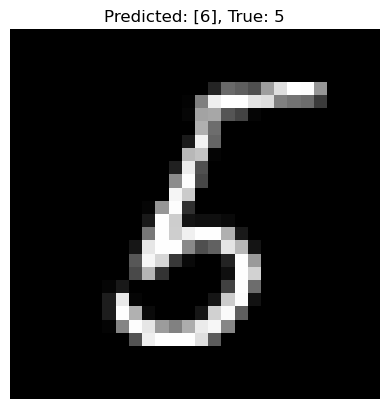

Misclassified index 1393: Predicted [7], True 5


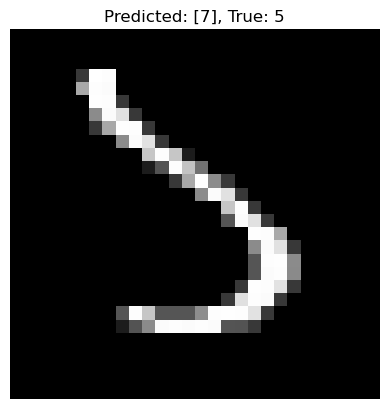

Misclassified index 1395: Predicted [3], True 2


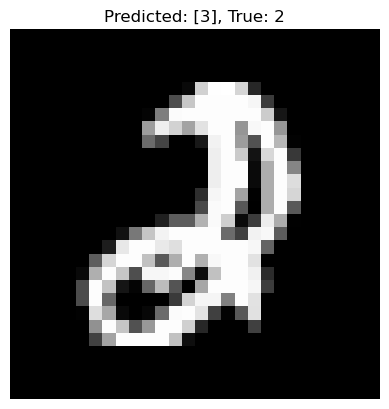

Misclassified index 1414: Predicted [7], True 9


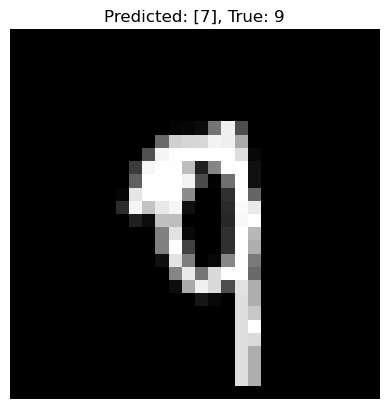

Misclassified index 1467: Predicted [9], True 5


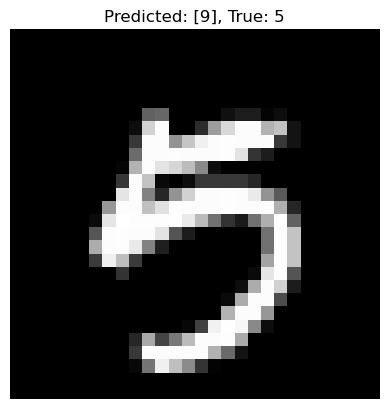

Misclassified index 1494: Predicted [9], True 7


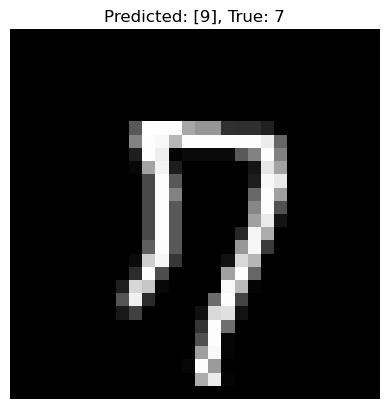

Misclassified index 1500: Predicted [1], True 7


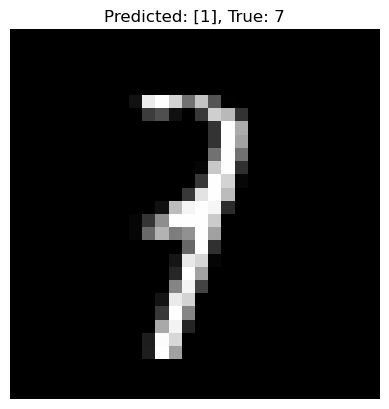

Misclassified index 1522: Predicted [9], True 7


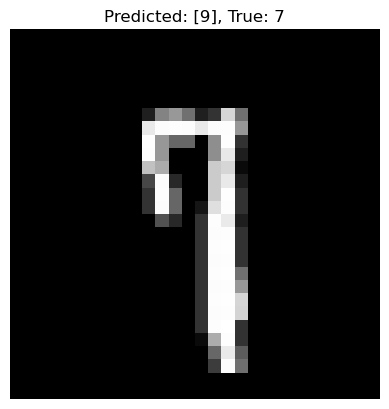

Misclassified index 1527: Predicted [6], True 1


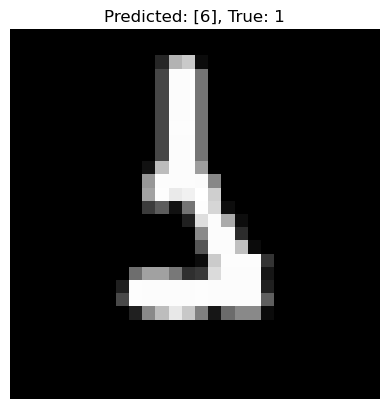

Misclassified index 1530: Predicted [7], True 8


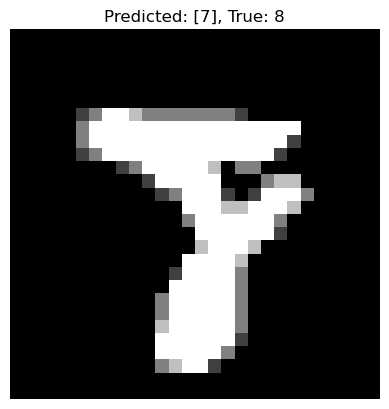

Misclassified index 1549: Predicted [6], True 4


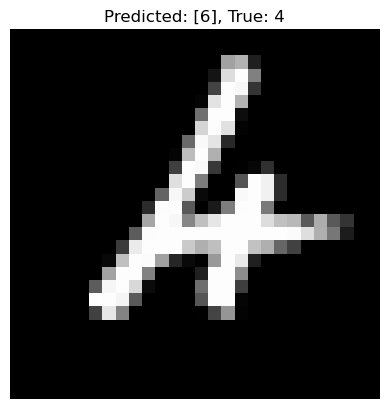

Misclassified index 1553: Predicted [8], True 9


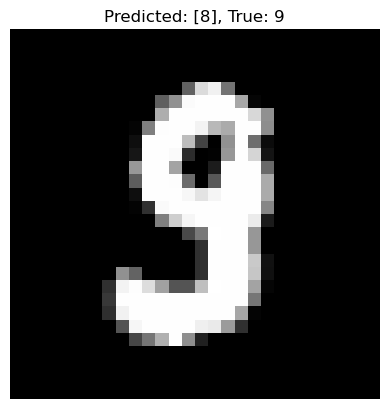

Misclassified index 1609: Predicted [6], True 2


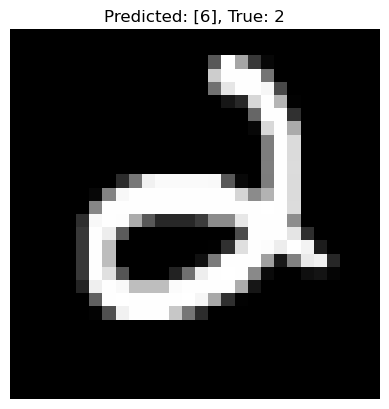

Misclassified index 1621: Predicted [6], True 0


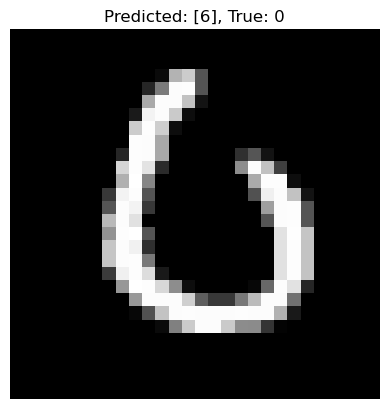

Misclassified index 1641: Predicted [8], True 5


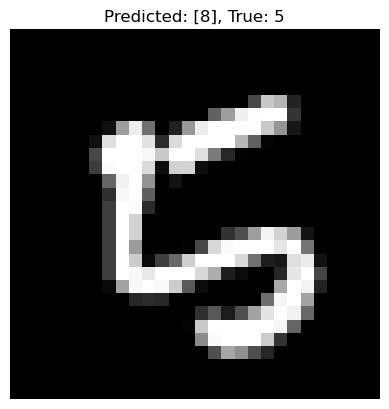

Misclassified index 1671: Predicted [3], True 7


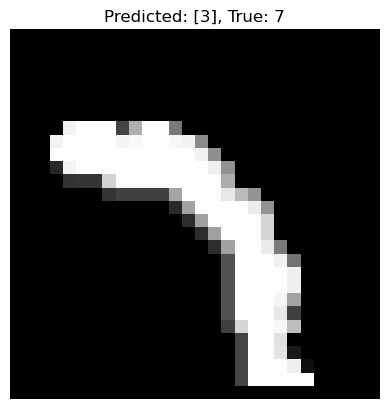

Misclassified index 1681: Predicted [7], True 3


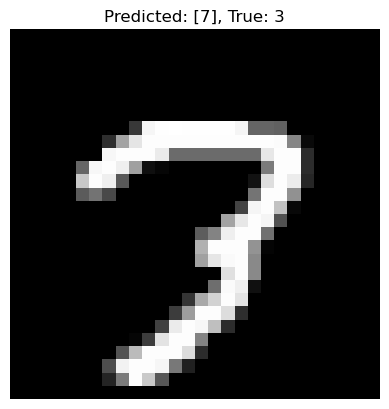

Misclassified index 1709: Predicted [3], True 9


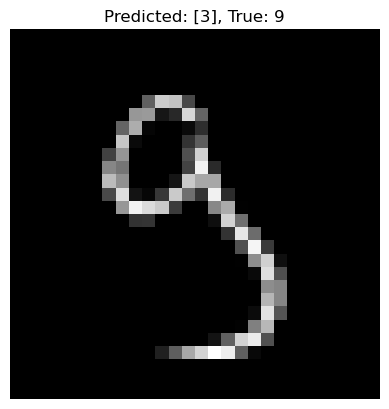

Misclassified index 1716: Predicted [1], True 7


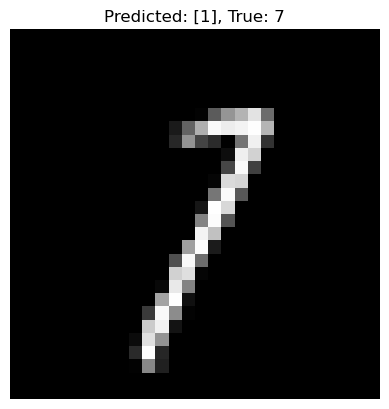

Misclassified index 1717: Predicted [0], True 8


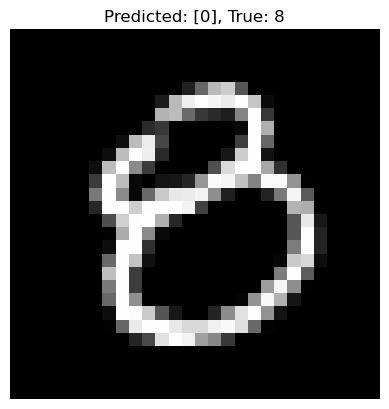

Misclassified index 1721: Predicted [9], True 7


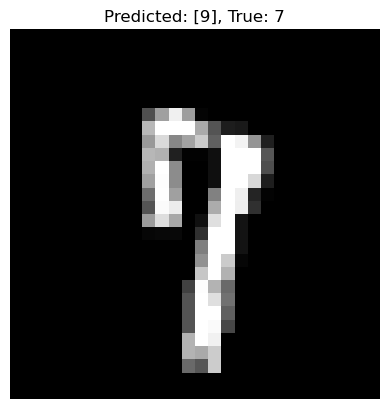

Misclassified index 1737: Predicted [2], True 5


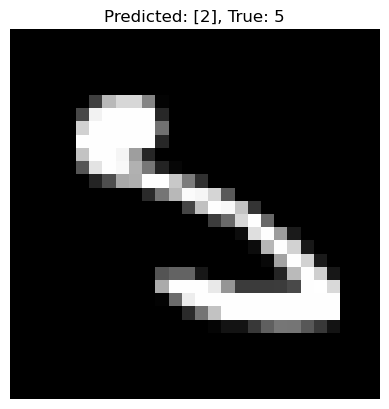

Misclassified index 1754: Predicted [2], True 7


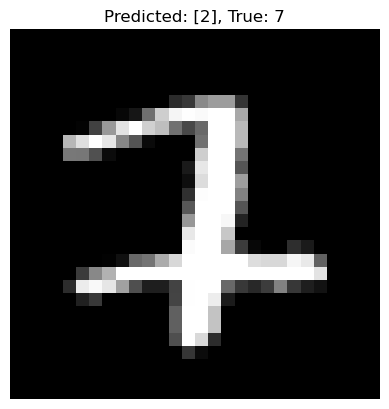

Misclassified index 1790: Predicted [9], True 2


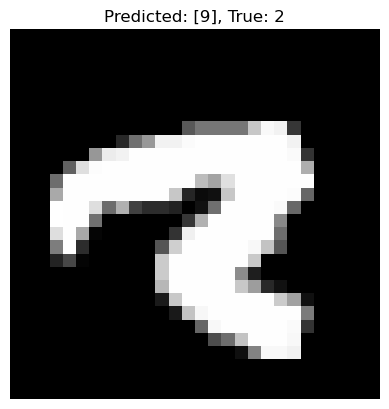

Misclassified index 1843: Predicted [2], True 0


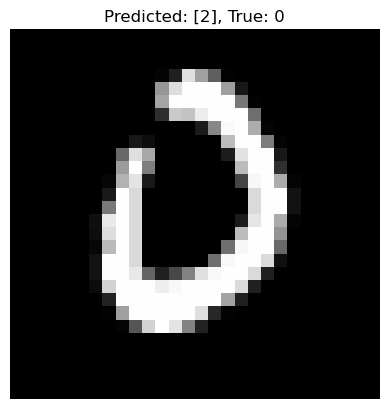

Misclassified index 1850: Predicted [7], True 8


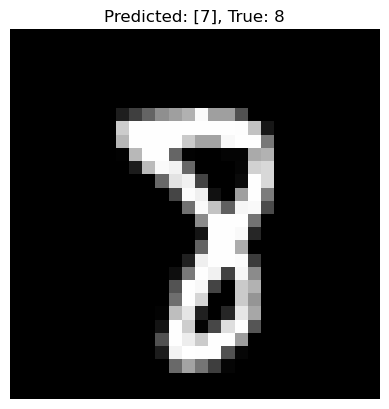

Misclassified index 1878: Predicted [3], True 8


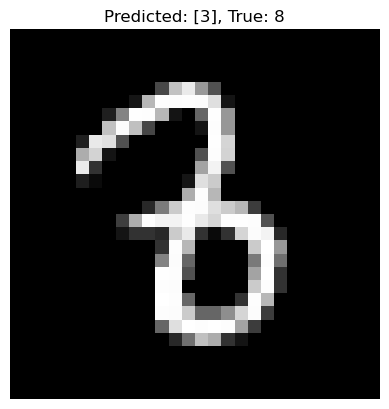

Misclassified index 1901: Predicted [4], True 9


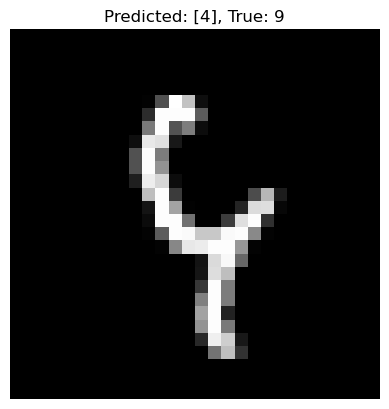

Misclassified index 1941: Predicted [8], True 7


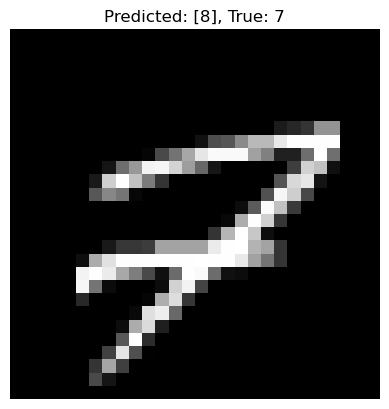

Misclassified index 1948: Predicted [4], True 5


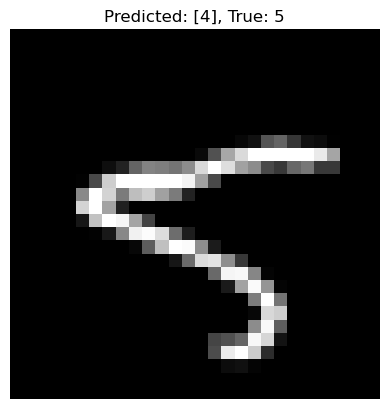

Misclassified index 1952: Predicted [8], True 9


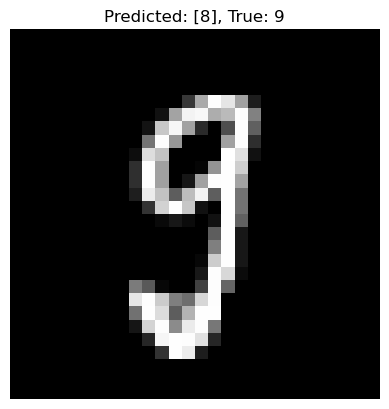

Misclassified index 1955: Predicted [2], True 8


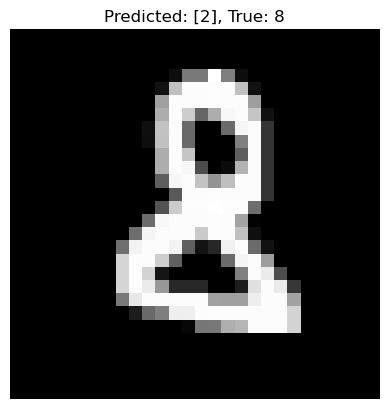

Misclassified index 1982: Predicted [5], True 6


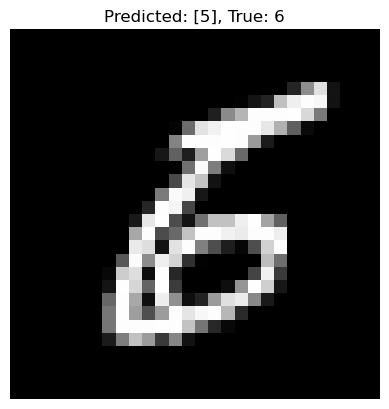

Misclassified index 1987: Predicted [9], True 0


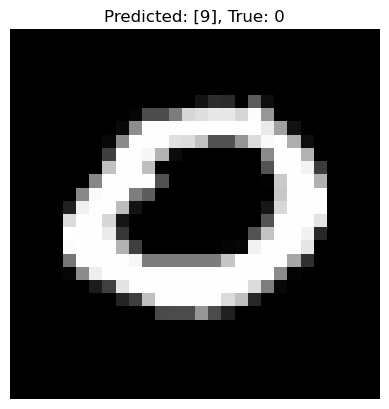

Misclassified index 2004: Predicted [3], True 8


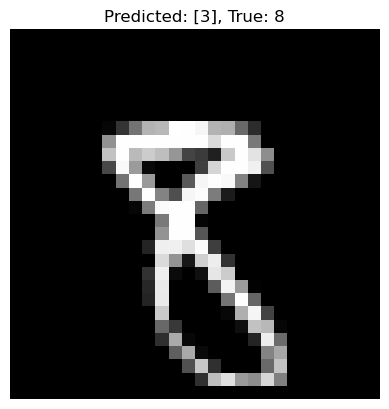

Misclassified index 2016: Predicted [2], True 7


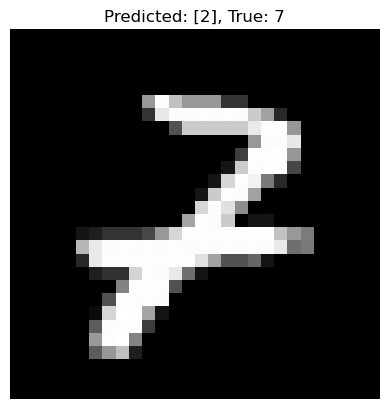

Misclassified index 2024: Predicted [9], True 7


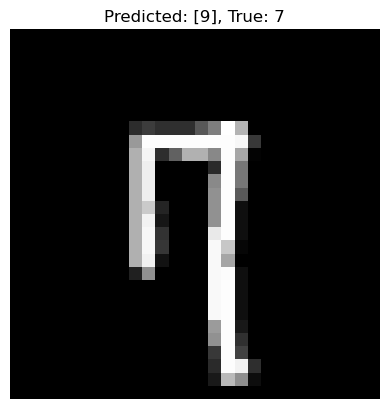

Misclassified index 2040: Predicted [2], True 5


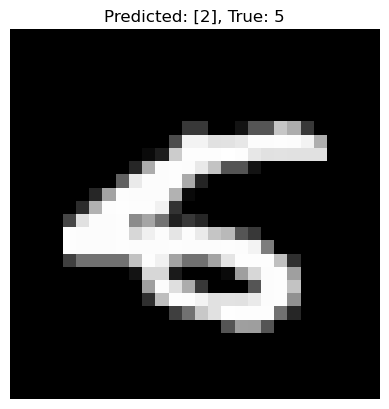

Misclassified index 2043: Predicted [8], True 4


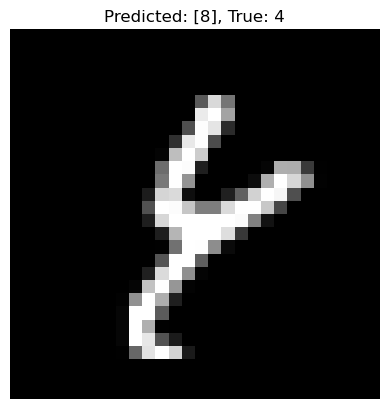

Misclassified index 2044: Predicted [7], True 2


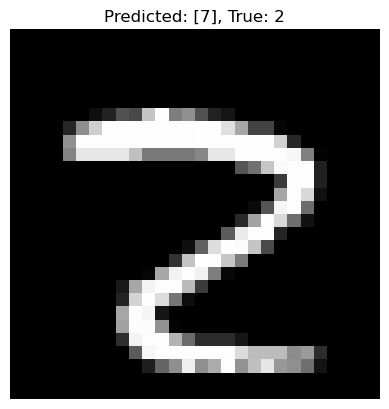

Misclassified index 2053: Predicted [9], True 4


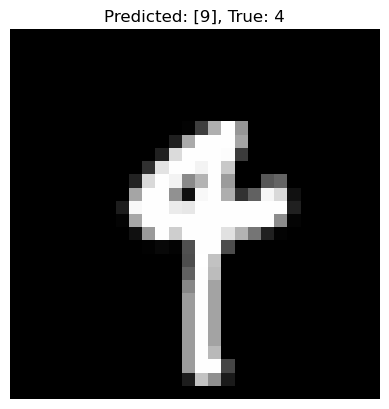

Misclassified index 2063: Predicted [5], True 7


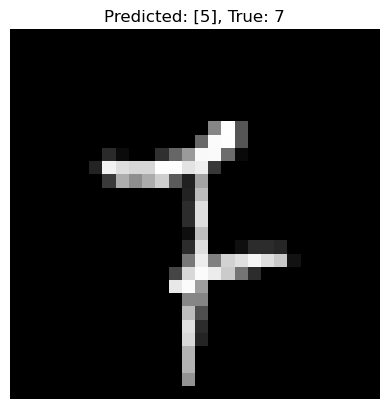

Misclassified index 2070: Predicted [4], True 7


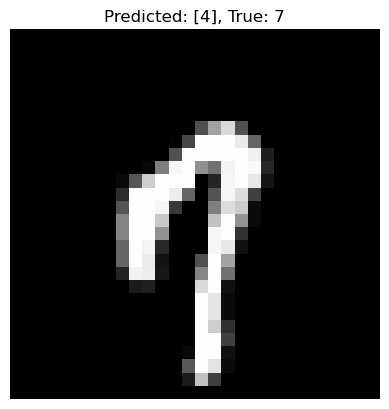

Misclassified index 2073: Predicted [0], True 5


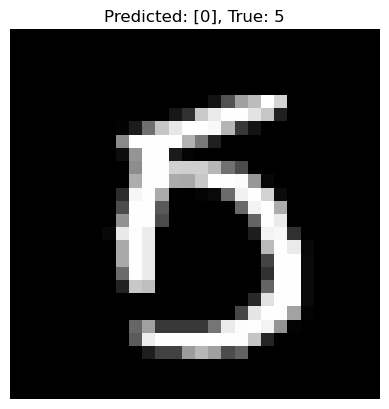

Misclassified index 2093: Predicted [1], True 8


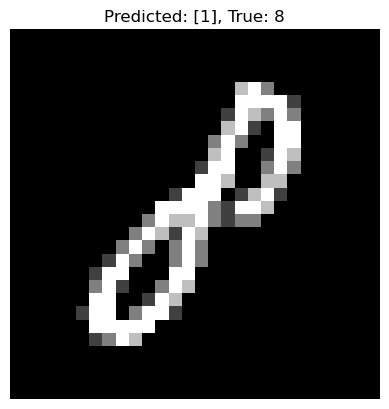

Misclassified index 2098: Predicted [0], True 2


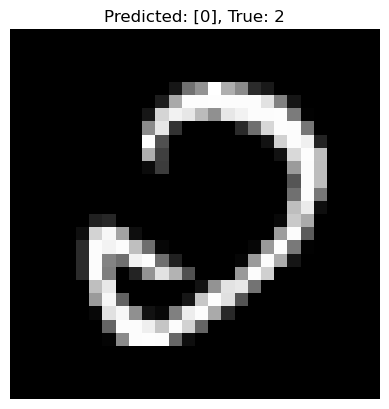

Misclassified index 2109: Predicted [9], True 3


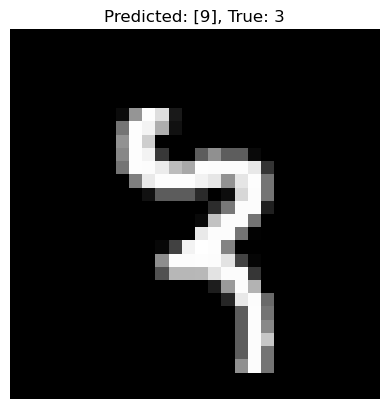

Misclassified index 2118: Predicted [0], True 6


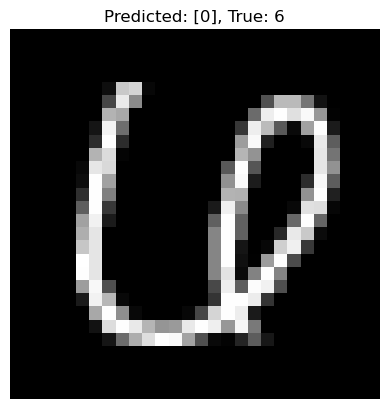

Misclassified index 2129: Predicted [2], True 9


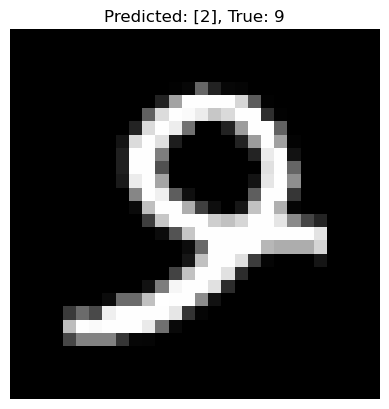

Misclassified index 2130: Predicted [9], True 4


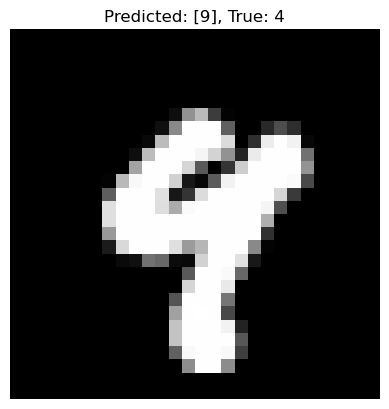

Misclassified index 2135: Predicted [1], True 6


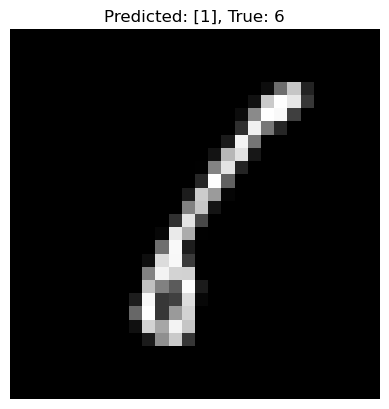

Misclassified index 2145: Predicted [2], True 4


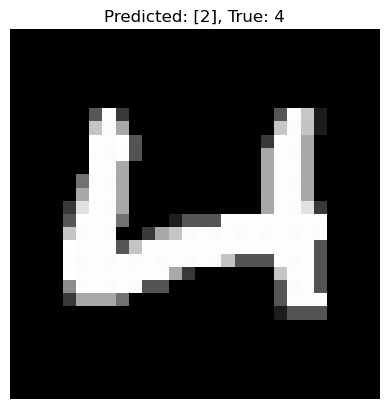

Misclassified index 2182: Predicted [2], True 1


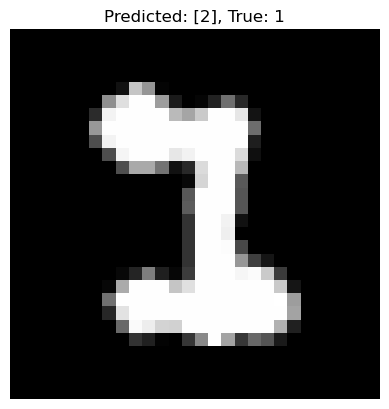

Misclassified index 2185: Predicted [5], True 0


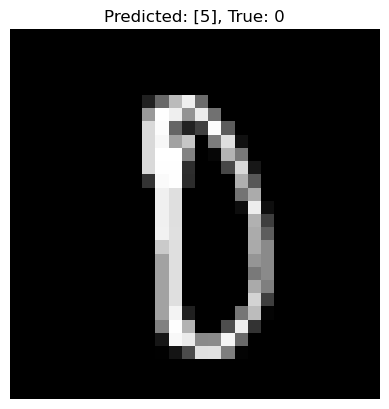

Misclassified index 2186: Predicted [3], True 2


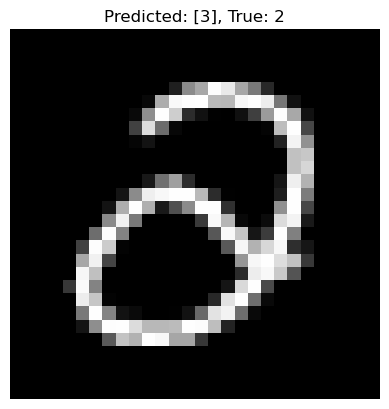

Misclassified index 2215: Predicted [5], True 6


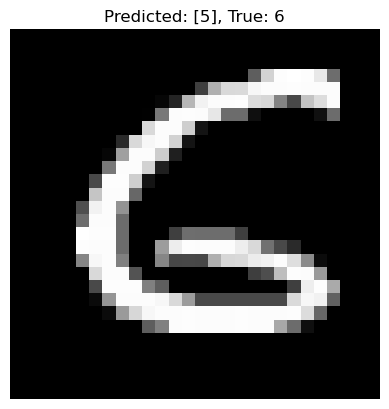

Misclassified index 2266: Predicted [6], True 1


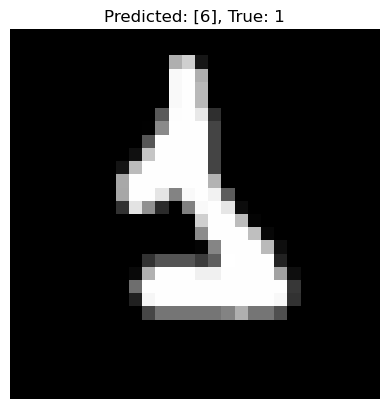

Misclassified index 2272: Predicted [0], True 8


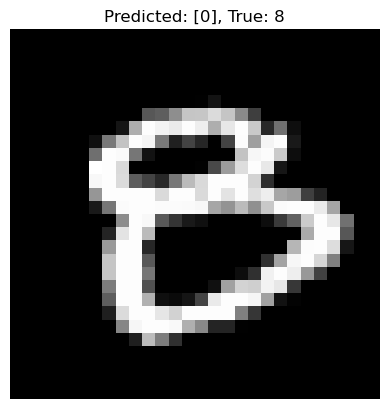

Misclassified index 2291: Predicted [3], True 5


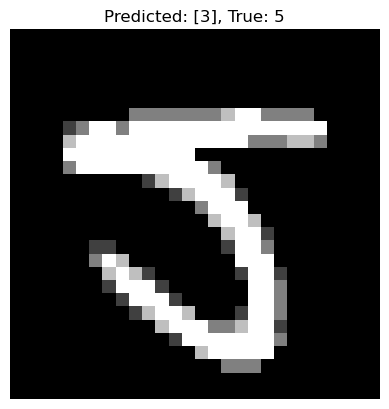

Misclassified index 2293: Predicted [0], True 9


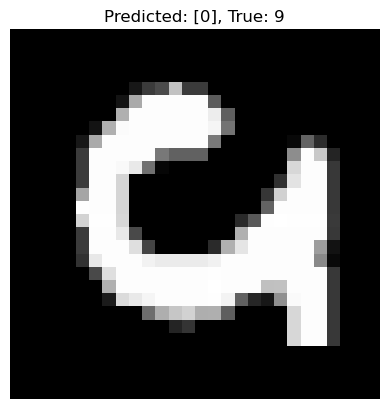

Misclassified index 2305: Predicted [8], True 3


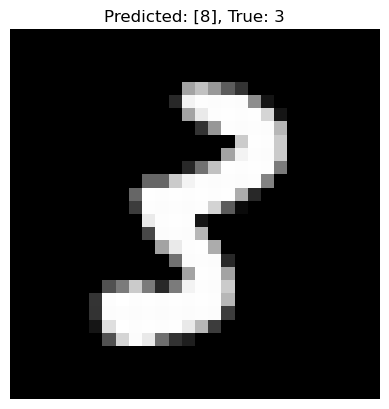

Misclassified index 2371: Predicted [9], True 4


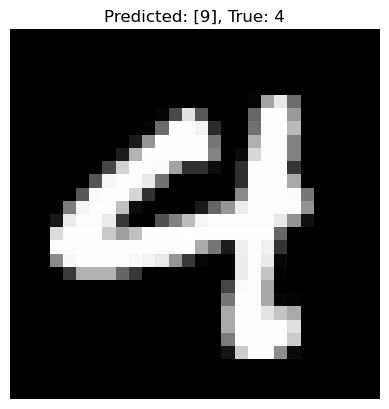

Misclassified index 2387: Predicted [1], True 9


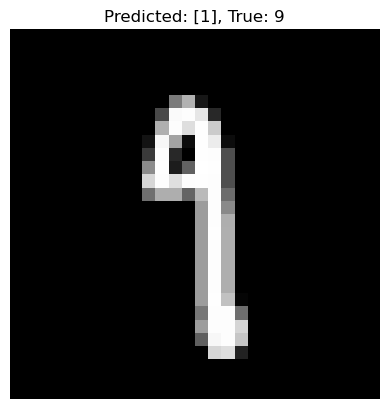

Misclassified index 2395: Predicted [3], True 8


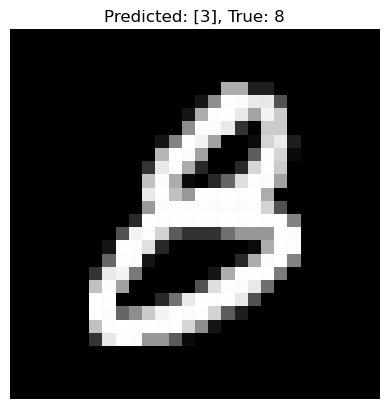

Misclassified index 2406: Predicted [1], True 9


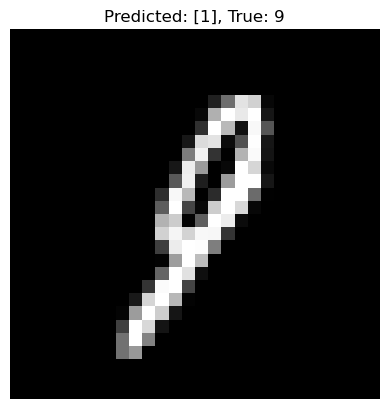

Misclassified index 2414: Predicted [4], True 9


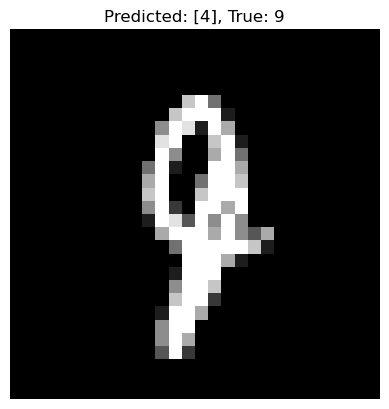

Misclassified index 2422: Predicted [4], True 6


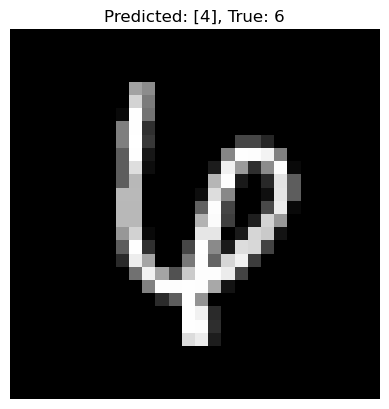

Misclassified index 2433: Predicted [1], True 2


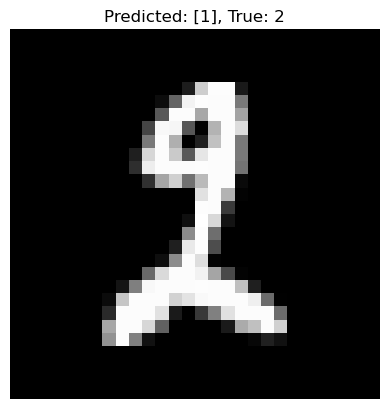

Misclassified index 2454: Predicted [8], True 6


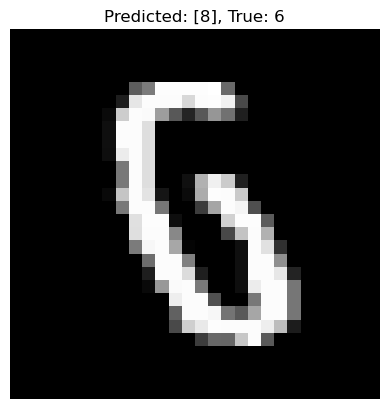

Misclassified index 2488: Predicted [4], True 2


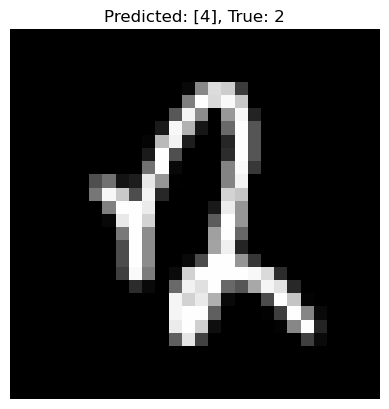

Misclassified index 2526: Predicted [3], True 5


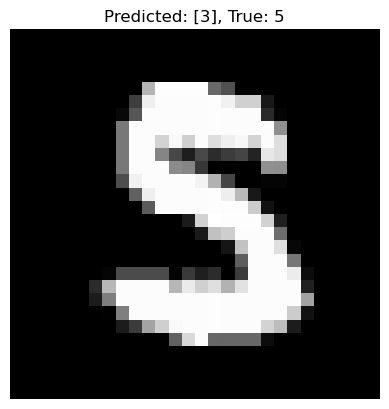

Misclassified index 2607: Predicted [1], True 7


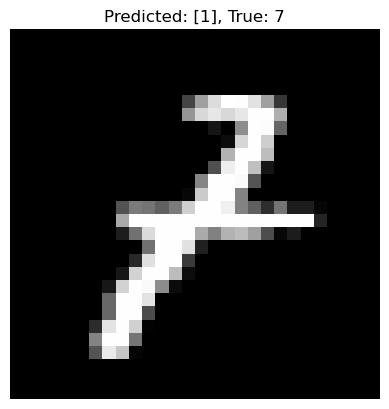

Misclassified index 2611: Predicted [6], True 5


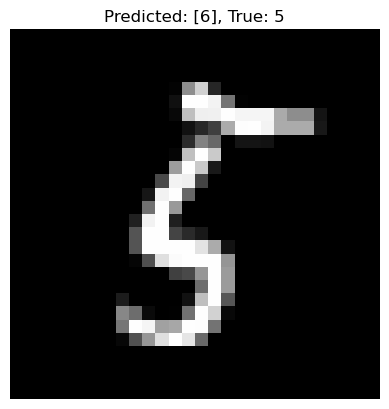

Misclassified index 2618: Predicted [5], True 3


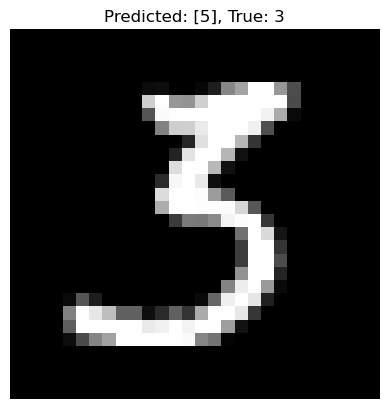

Misclassified index 2648: Predicted [0], True 9


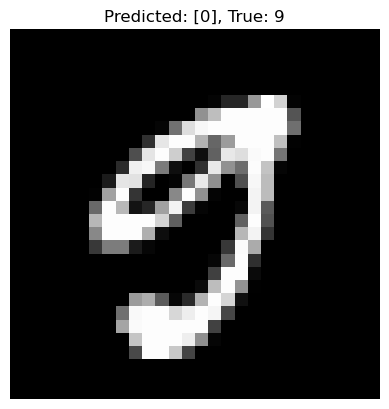

Misclassified index 2654: Predicted [1], True 6


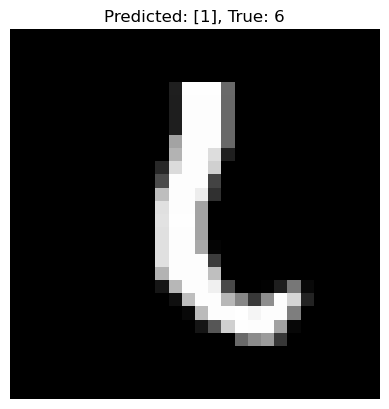

Misclassified index 2720: Predicted [4], True 9


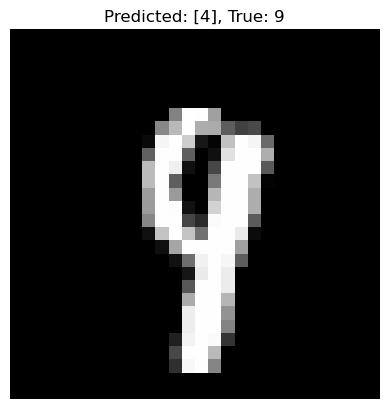

Misclassified index 2721: Predicted [5], True 6


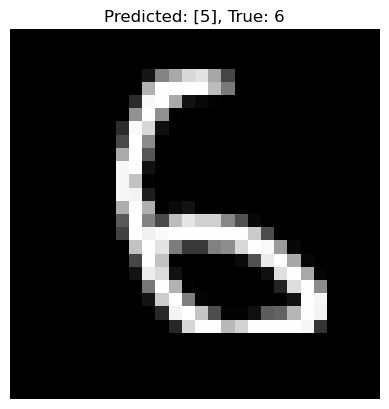

Misclassified index 2730: Predicted [4], True 7


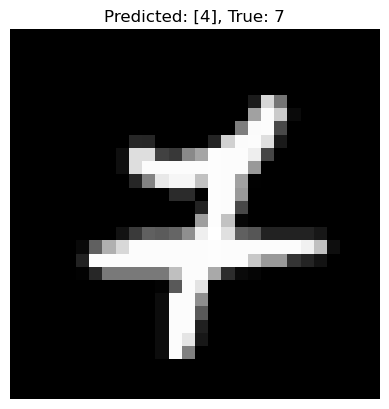

Misclassified index 2743: Predicted [8], True 5


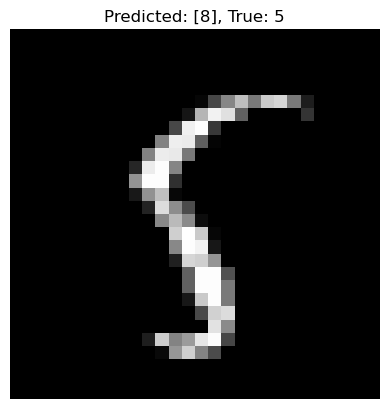

Misclassified index 2863: Predicted [4], True 9


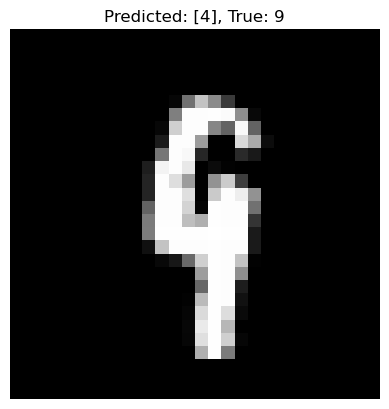

Misclassified index 2896: Predicted [0], True 8


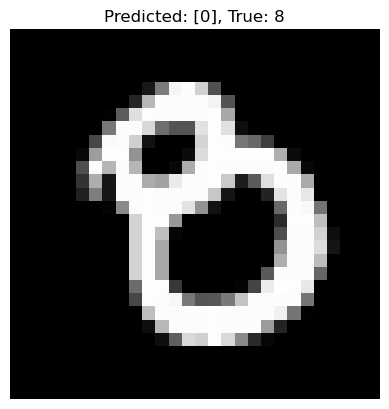

Misclassified index 2915: Predicted [3], True 7


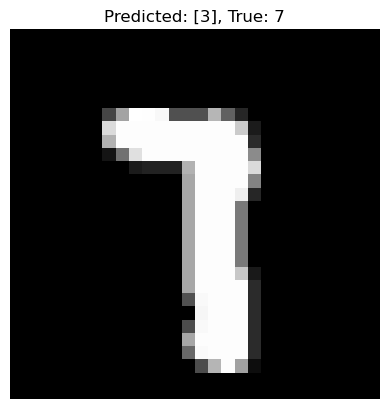

Misclassified index 2921: Predicted [0], True 3


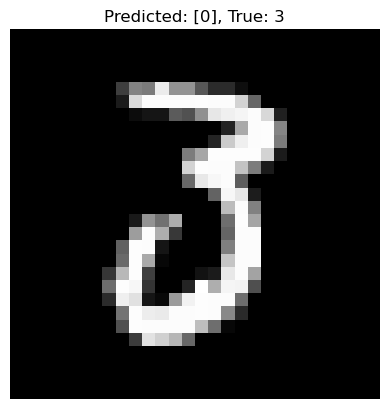

Misclassified index 2927: Predicted [2], True 3


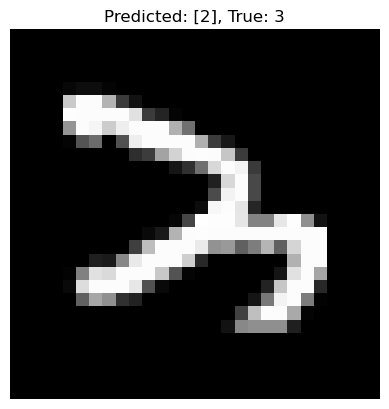

Misclassified index 2939: Predicted [5], True 9


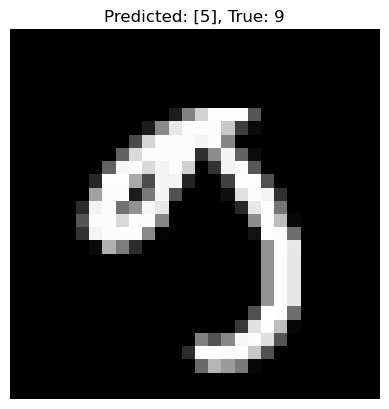

Misclassified index 2953: Predicted [5], True 3


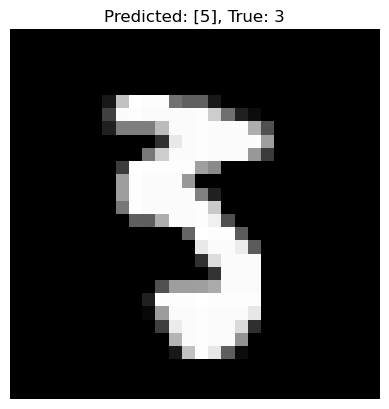

Misclassified index 2995: Predicted [5], True 6


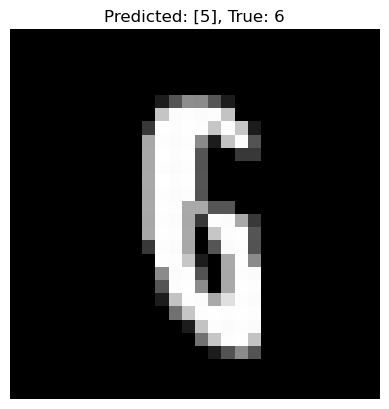

Misclassified index 3005: Predicted [1], True 9


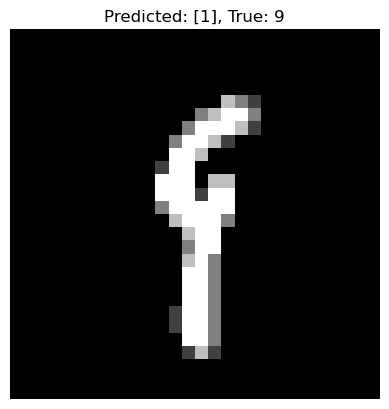

Misclassified index 3030: Predicted [8], True 6


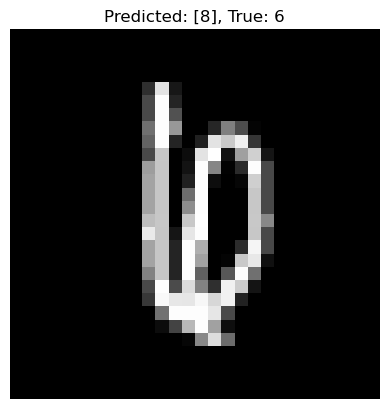

Misclassified index 3060: Predicted [7], True 9


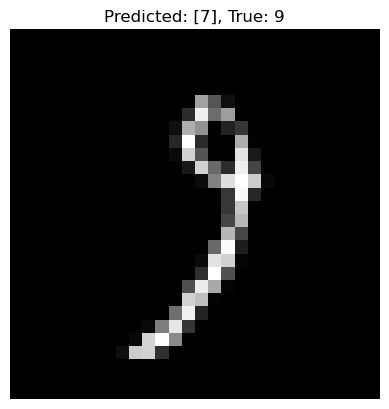

Misclassified index 3073: Predicted [2], True 1


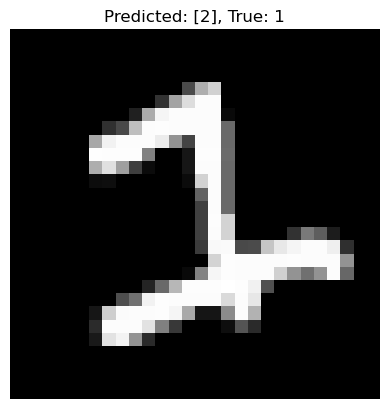

Misclassified index 3110: Predicted [5], True 3


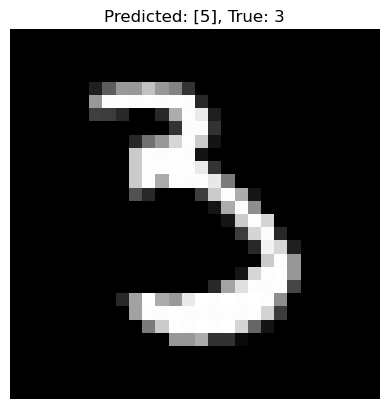

Misclassified index 3115: Predicted [4], True 5


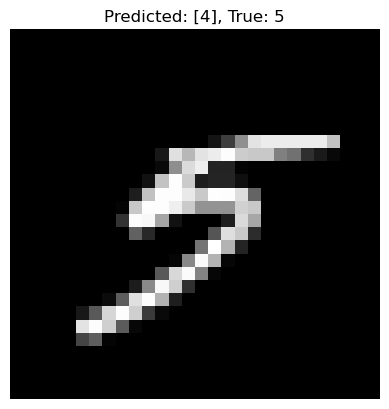

Misclassified index 3117: Predicted [3], True 5


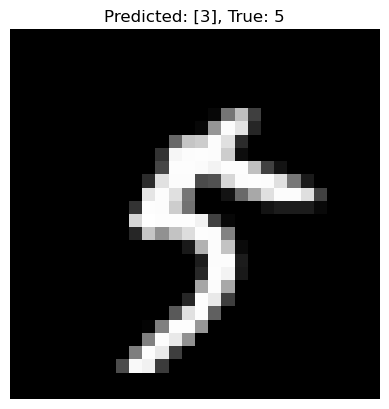

Misclassified index 3132: Predicted [2], True 1


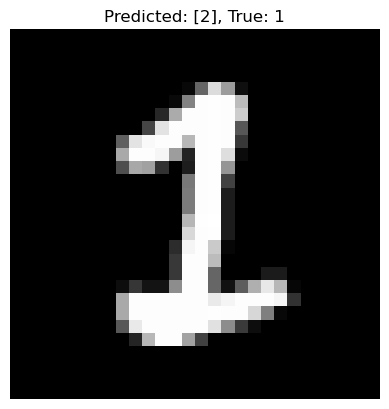

Misclassified index 3206: Predicted [3], True 8


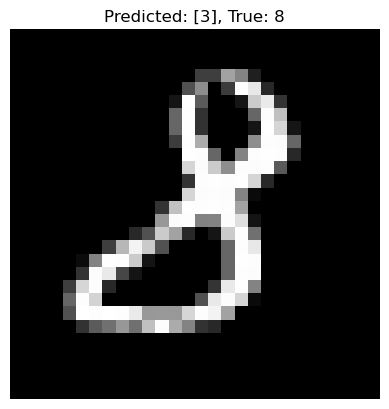

Misclassified index 3225: Predicted [9], True 7


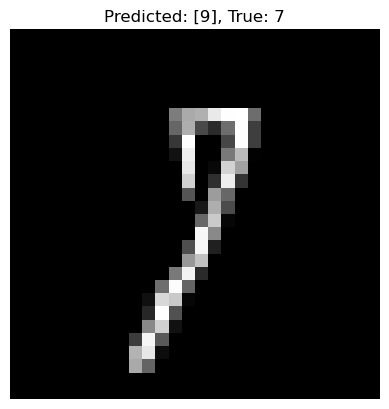

Misclassified index 3289: Predicted [9], True 8


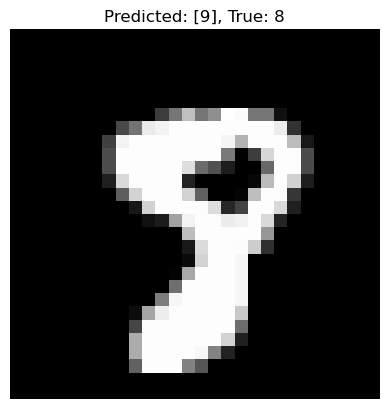

Misclassified index 3330: Predicted [3], True 2


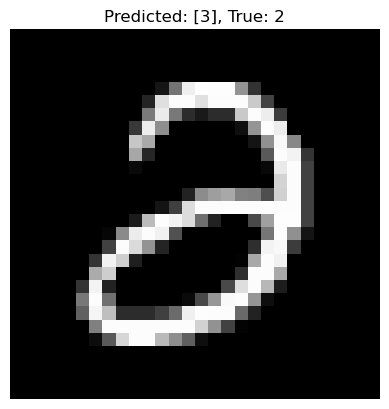

Misclassified index 3336: Predicted [7], True 5


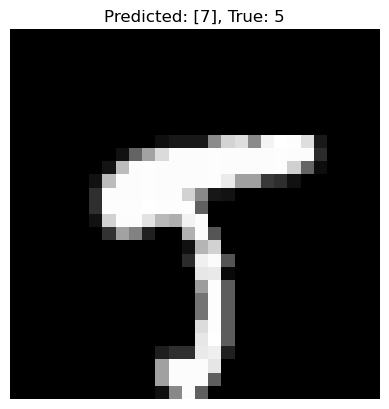

Misclassified index 3369: Predicted [1], True 9


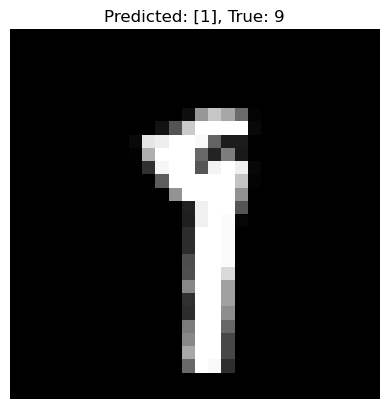

Misclassified index 3376: Predicted [9], True 7


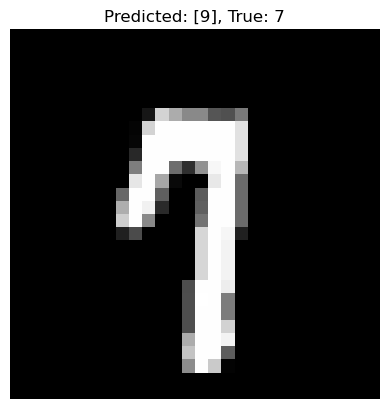

Misclassified index 3384: Predicted [5], True 2


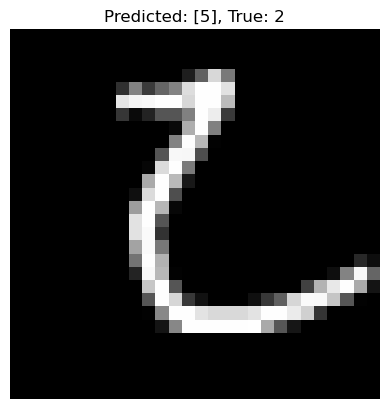

Misclassified index 3405: Predicted [9], True 4


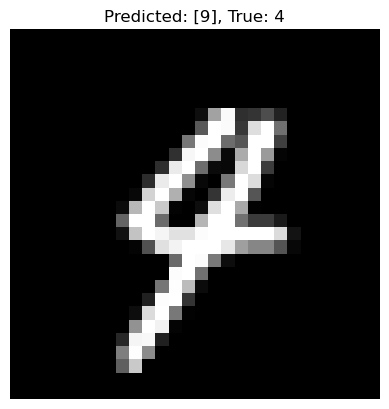

Misclassified index 3422: Predicted [0], True 6


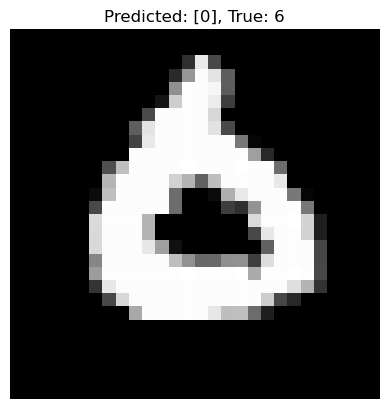

Misclassified index 3503: Predicted [1], True 9


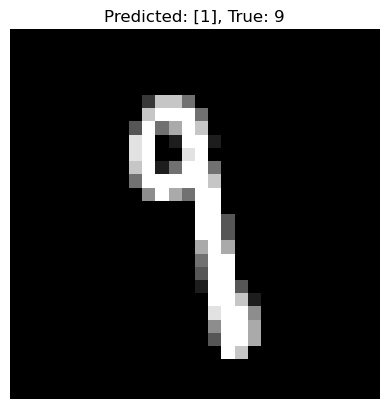

Misclassified index 3520: Predicted [4], True 6


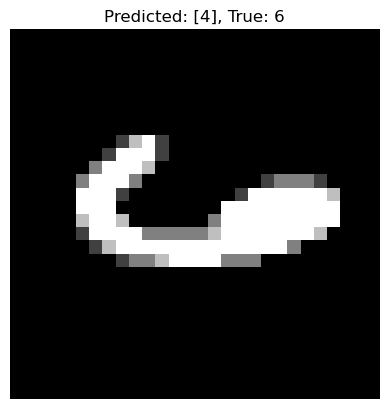

Misclassified index 3534: Predicted [8], True 4


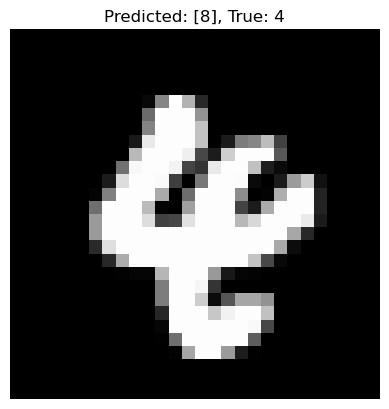

Misclassified index 3542: Predicted [2], True 4


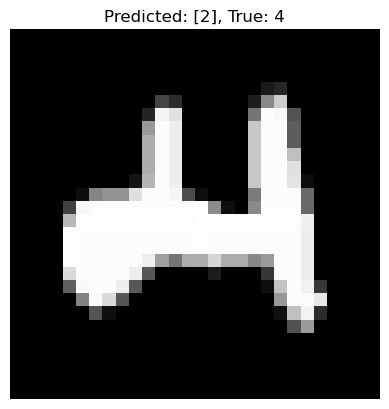

Misclassified index 3549: Predicted [2], True 3


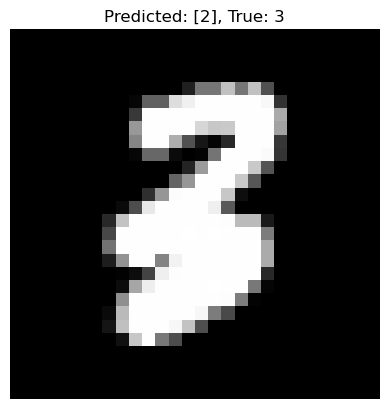

Misclassified index 3558: Predicted [0], True 5


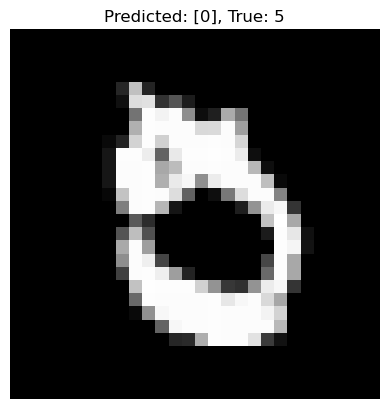

Misclassified index 3565: Predicted [8], True 5


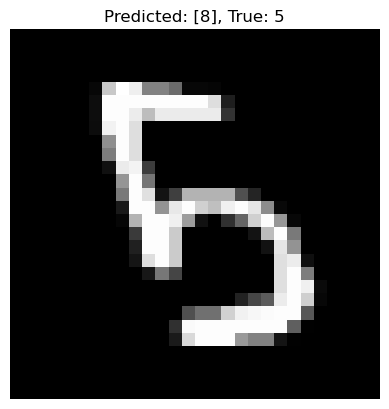

Misclassified index 3567: Predicted [5], True 8


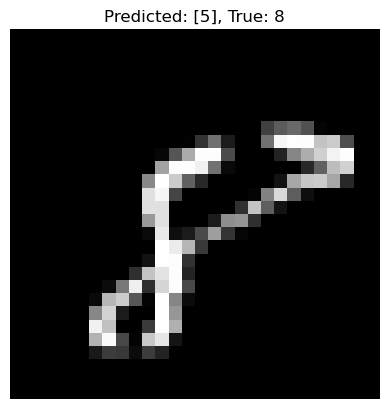

Misclassified index 3575: Predicted [8], True 7


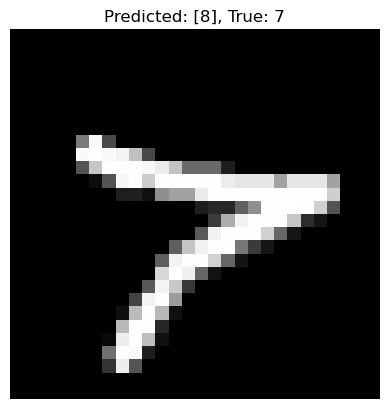

Misclassified index 3597: Predicted [3], True 9


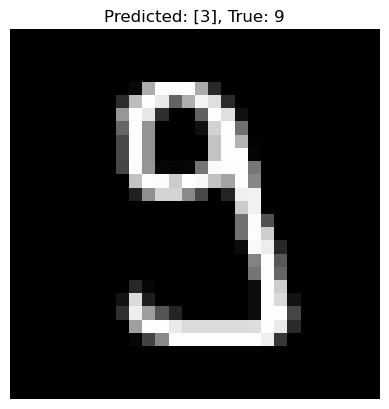

Misclassified index 3599: Predicted [7], True 2


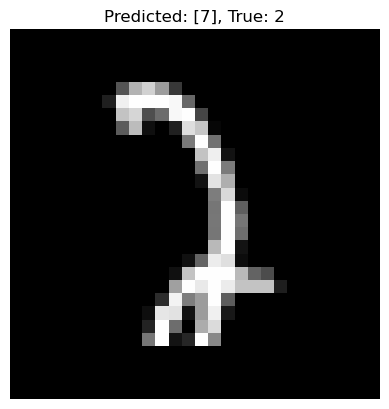

Misclassified index 3662: Predicted [5], True 8


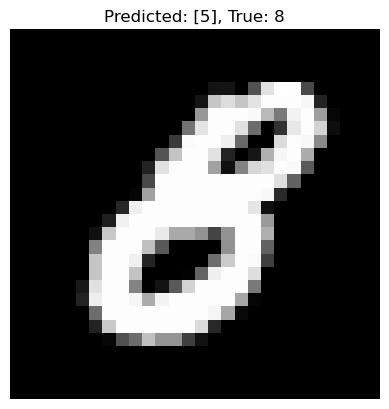

Misclassified index 3718: Predicted [9], True 4


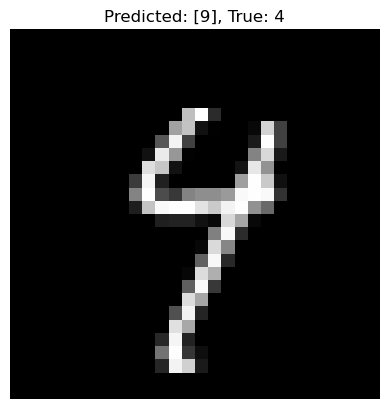

Misclassified index 3757: Predicted [3], True 8


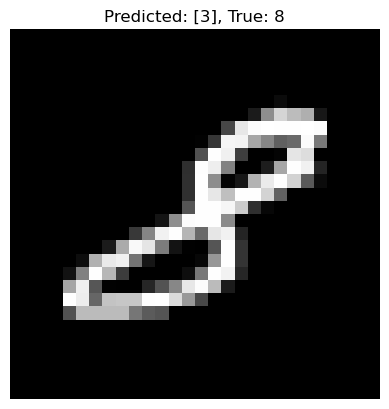

Misclassified index 3762: Predicted [5], True 6


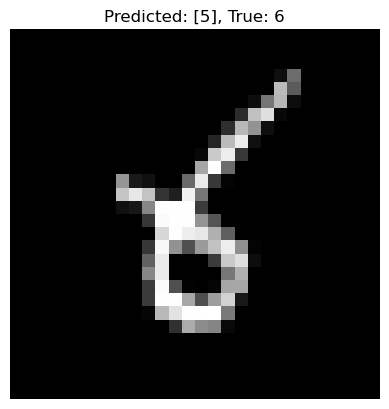

Misclassified index 3763: Predicted [7], True 5


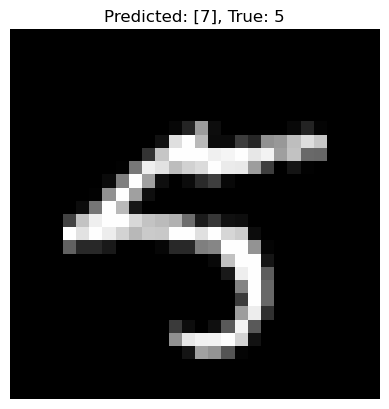

Misclassified index 3767: Predicted [2], True 7


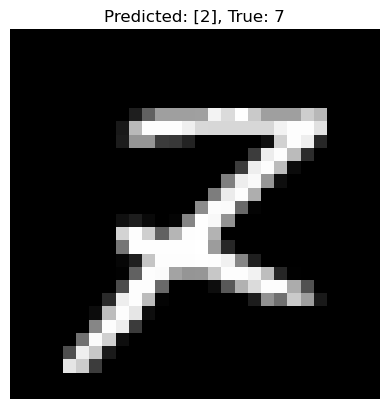

Misclassified index 3776: Predicted [8], True 5


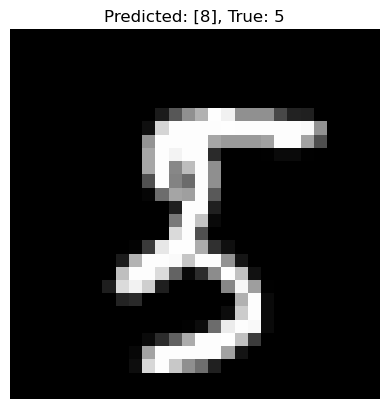

Misclassified index 3780: Predicted [6], True 4


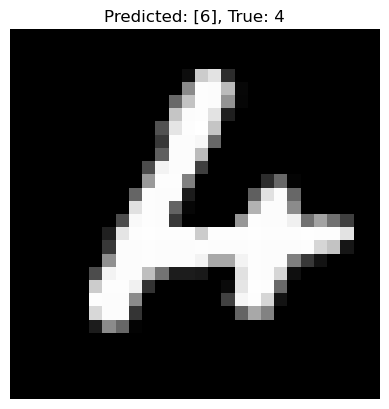

Misclassified index 3808: Predicted [3], True 7


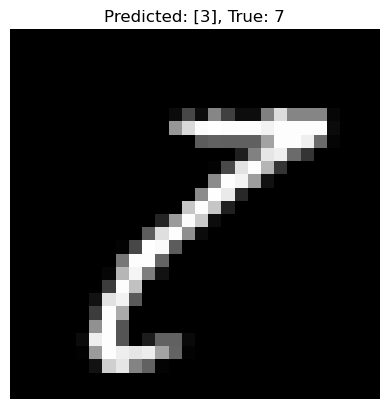

Misclassified index 3818: Predicted [6], True 0


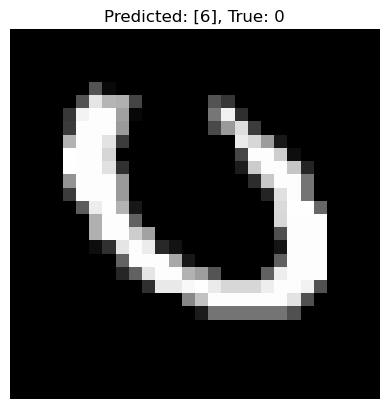

Misclassified index 3853: Predicted [0], True 6


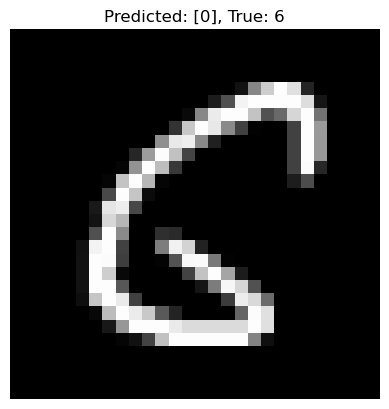

Misclassified index 3855: Predicted [0], True 5


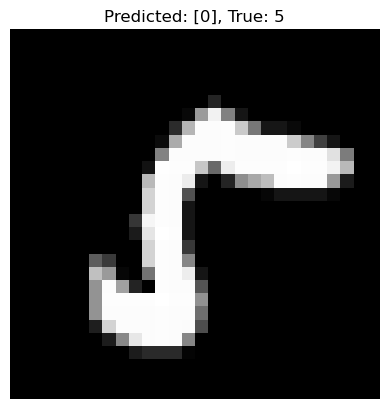

Misclassified index 3869: Predicted [4], True 9


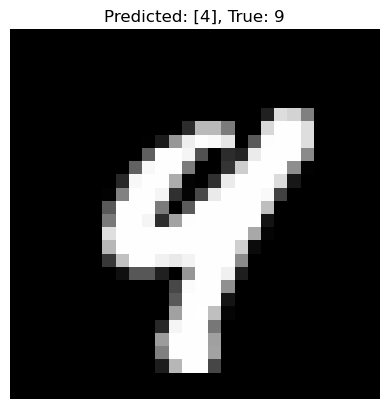

Misclassified index 3893: Predicted [6], True 5


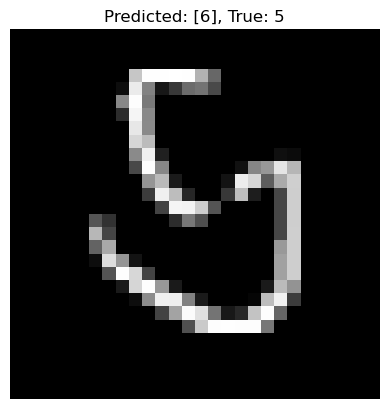

Misclassified index 3906: Predicted [2], True 1


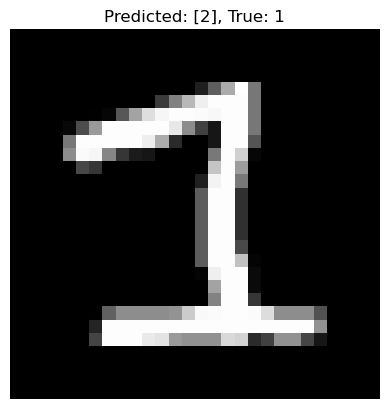

Misclassified index 3926: Predicted [3], True 9


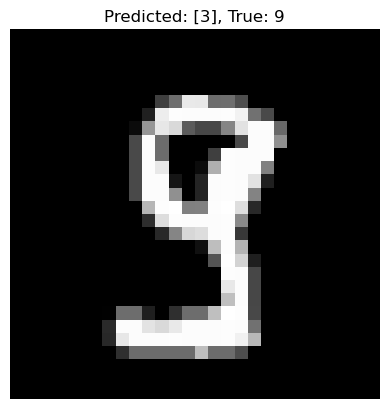

Misclassified index 3941: Predicted [2], True 4


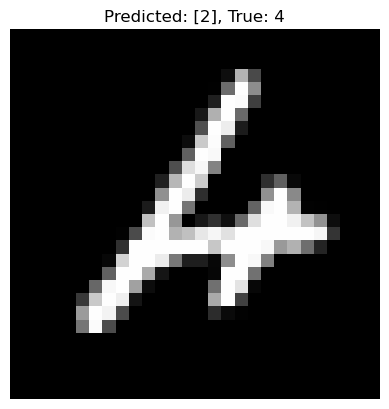

Misclassified index 3943: Predicted [5], True 3


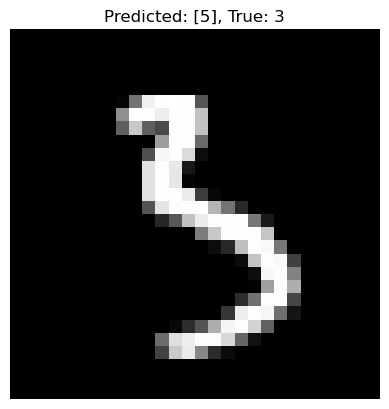

Misclassified index 3951: Predicted [2], True 8


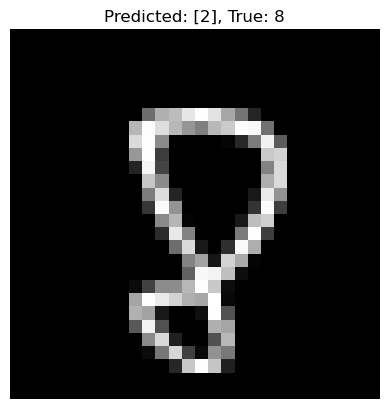

Misclassified index 3976: Predicted [1], True 7


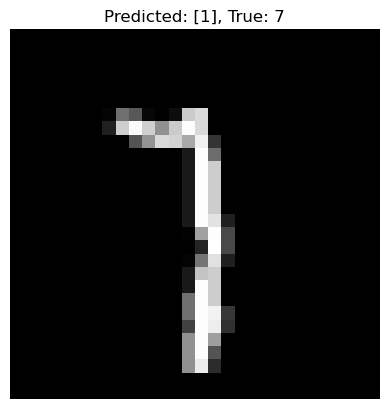

Misclassified index 3985: Predicted [4], True 9


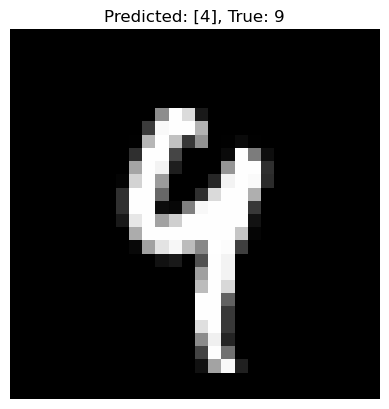

Misclassified index 3995: Predicted [5], True 3


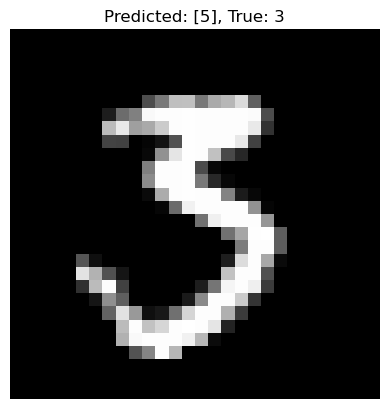

Misclassified index 4000: Predicted [4], True 9


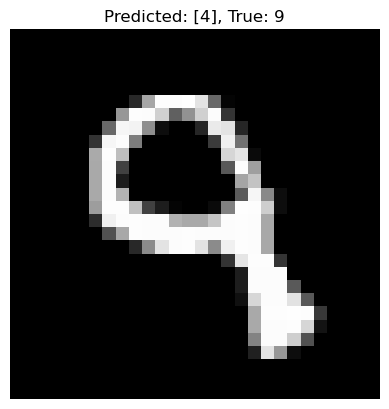

Misclassified index 4063: Predicted [5], True 6


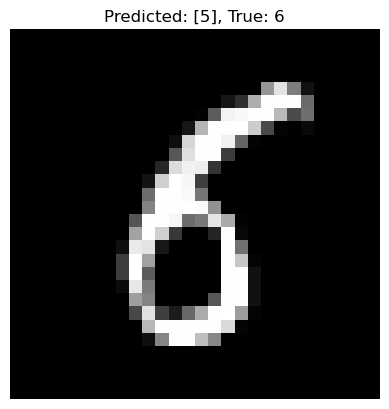

Misclassified index 4065: Predicted [4], True 0


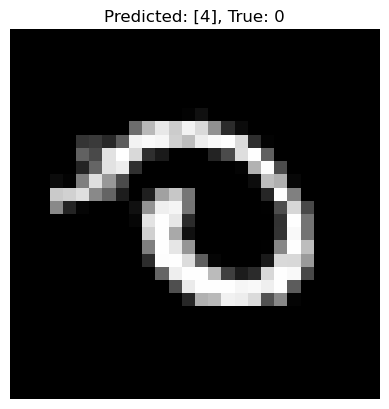

Misclassified index 4075: Predicted [0], True 8


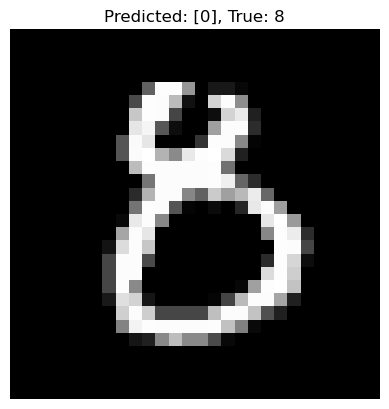

Misclassified index 4078: Predicted [3], True 9


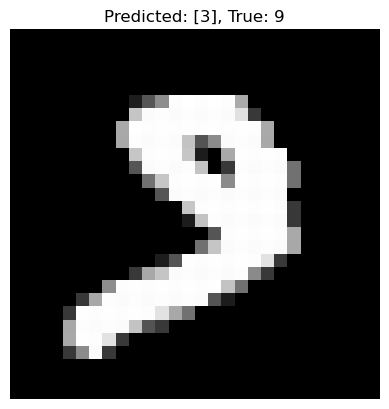

Misclassified index 4093: Predicted [4], True 9


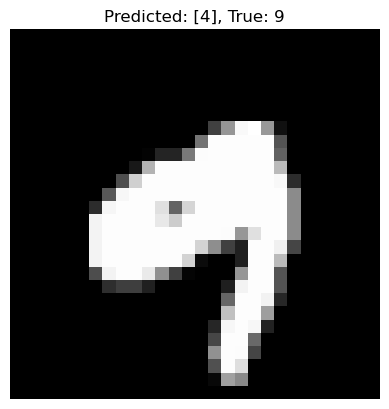

Misclassified index 4154: Predicted [4], True 9


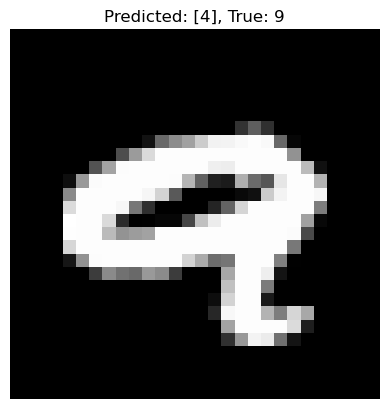

Misclassified index 4163: Predicted [0], True 9


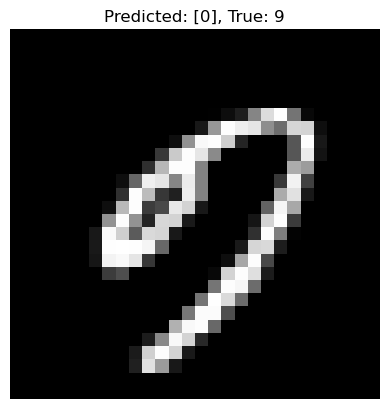

Misclassified index 4199: Predicted [9], True 7


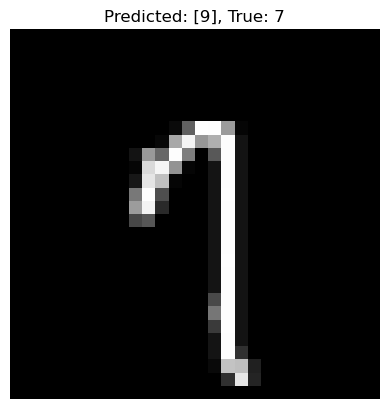

Misclassified index 4201: Predicted [7], True 1


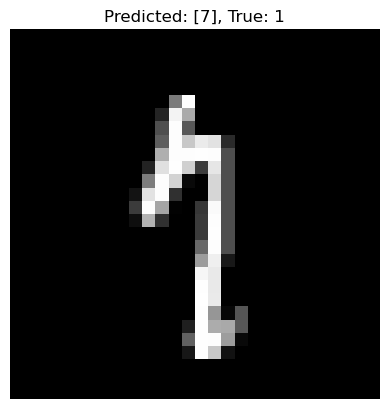

Misclassified index 4211: Predicted [5], True 6


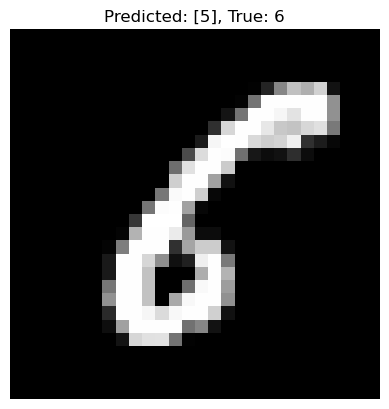

Misclassified index 4212: Predicted [3], True 1


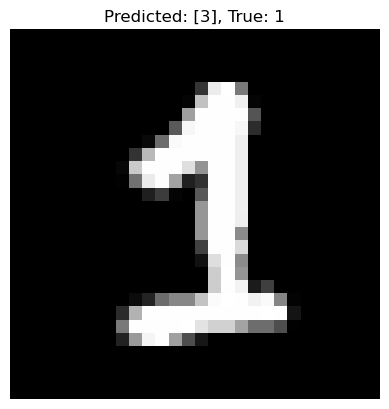

Misclassified index 4224: Predicted [7], True 9


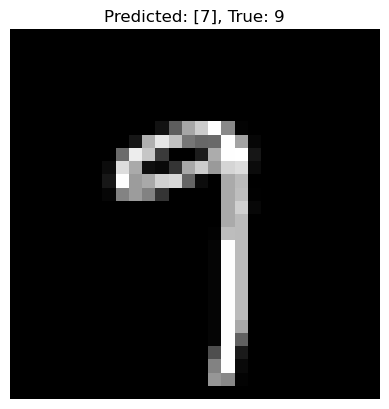

Misclassified index 4248: Predicted [8], True 2


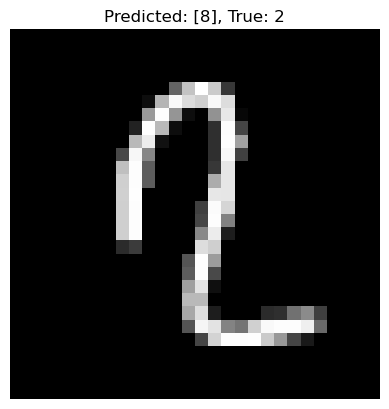

Misclassified index 4289: Predicted [7], True 2


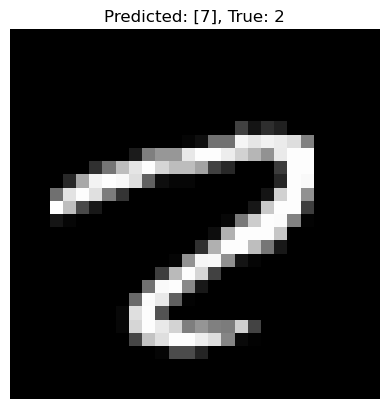

Misclassified index 4355: Predicted [9], True 5


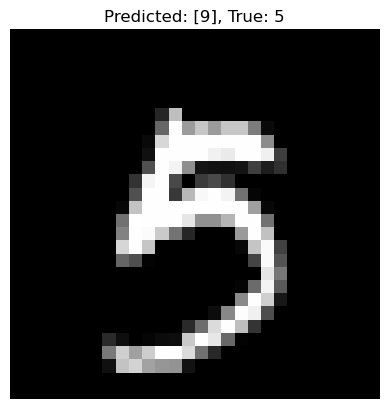

Misclassified index 4369: Predicted [4], True 9


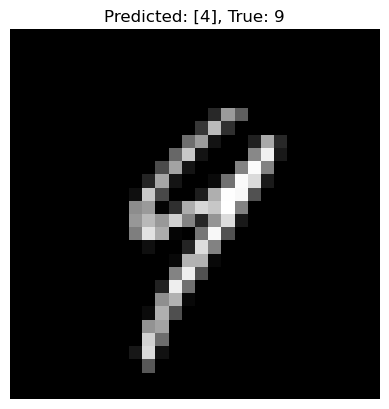

Misclassified index 4382: Predicted [9], True 4


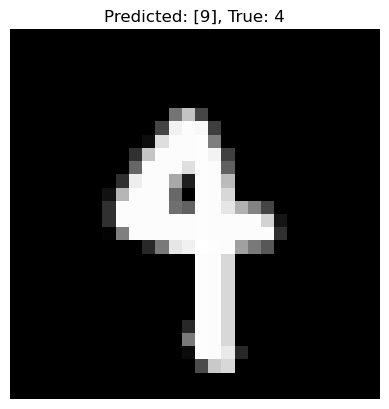

Misclassified index 4400: Predicted [1], True 7


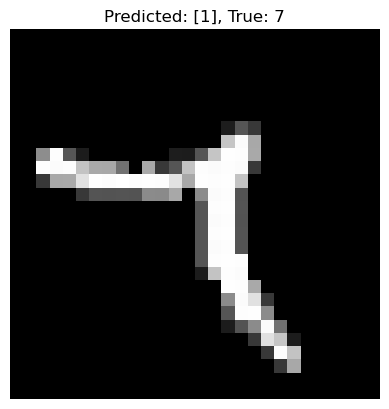

Misclassified index 4405: Predicted [4], True 9


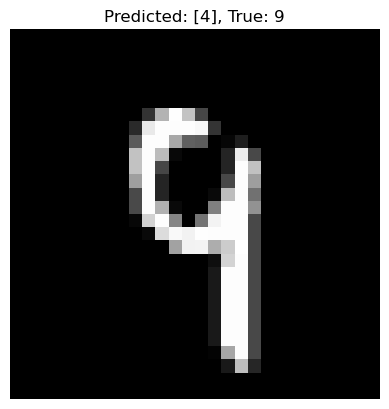

Misclassified index 4425: Predicted [4], True 9


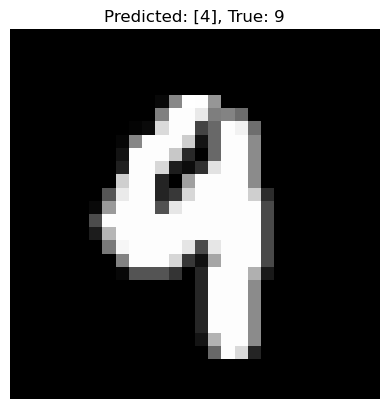

Misclassified index 4439: Predicted [4], True 6


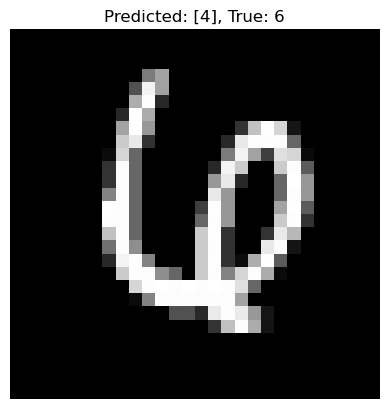

Misclassified index 4451: Predicted [8], True 2


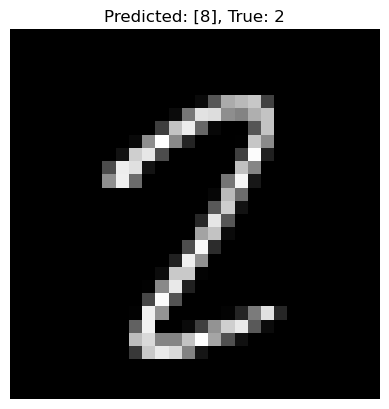

Misclassified index 4497: Predicted [7], True 8


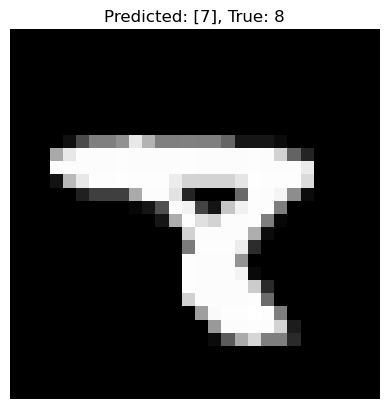

Misclassified index 4498: Predicted [4], True 7


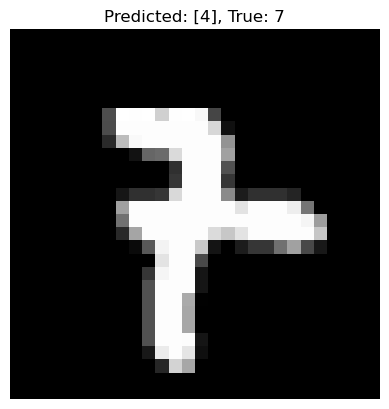

Misclassified index 4500: Predicted [1], True 9


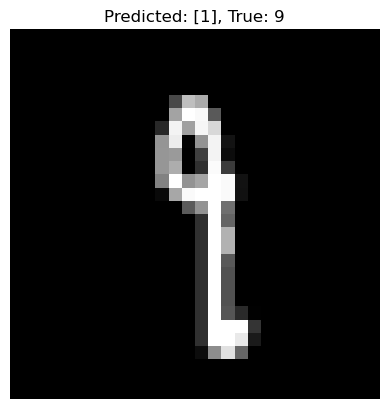

Misclassified index 4534: Predicted [8], True 9


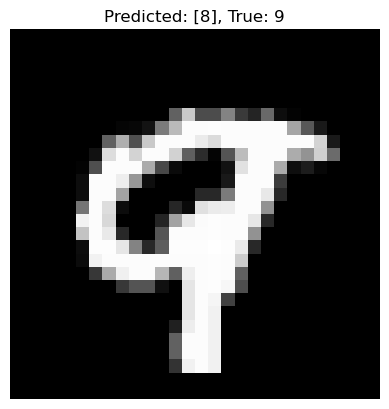

Misclassified index 4536: Predicted [5], True 6


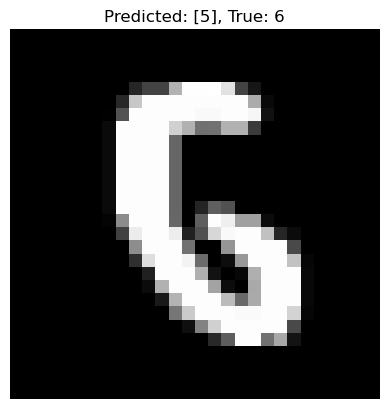

Misclassified index 4548: Predicted [6], True 5


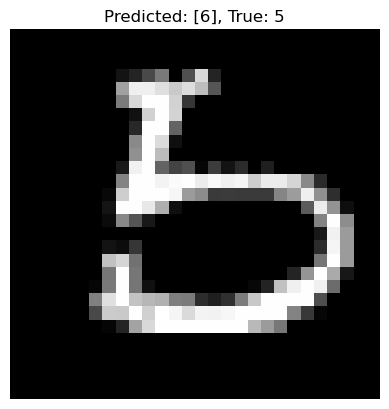

Misclassified index 4601: Predicted [4], True 8


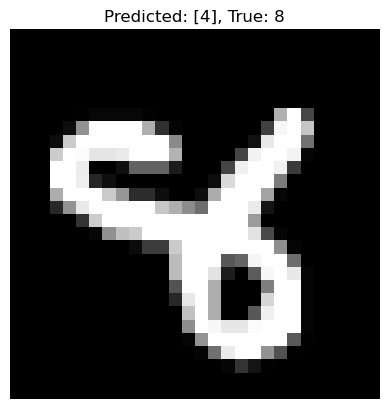

Misclassified index 4635: Predicted [5], True 3


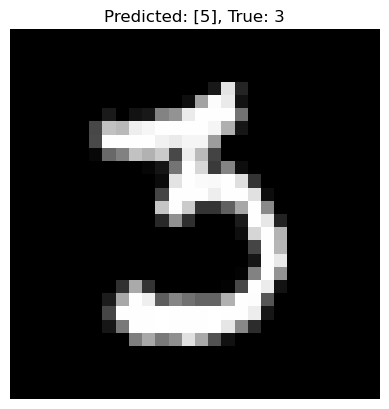

Misclassified index 4639: Predicted [9], True 8


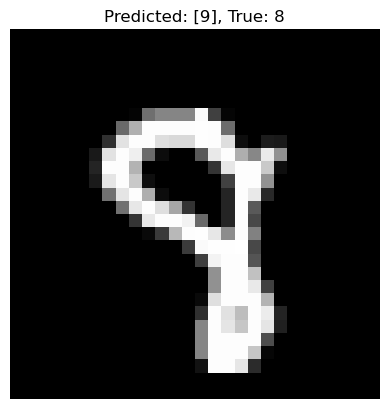

Misclassified index 4690: Predicted [2], True 7


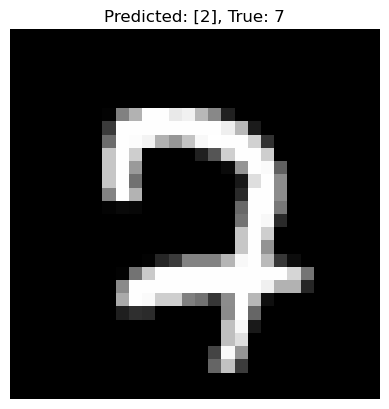

Misclassified index 4740: Predicted [5], True 3


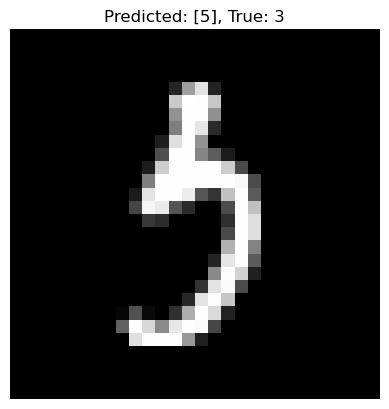

Misclassified index 4761: Predicted [4], True 9


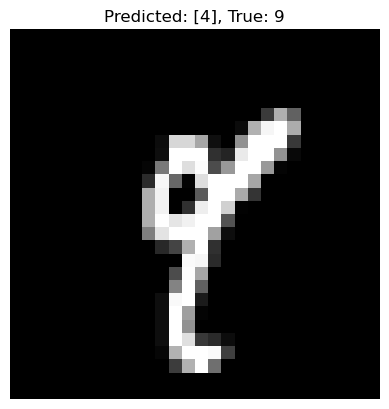

Misclassified index 4807: Predicted [3], True 8


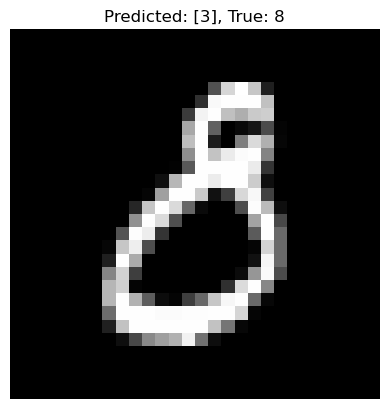

Misclassified index 4823: Predicted [4], True 9


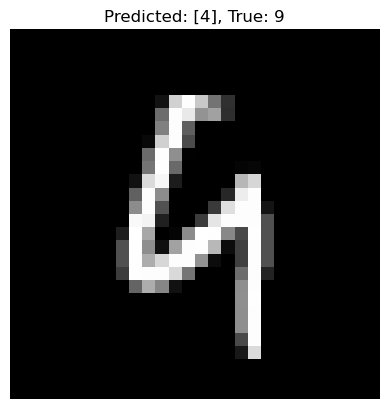

Misclassified index 4829: Predicted [3], True 8


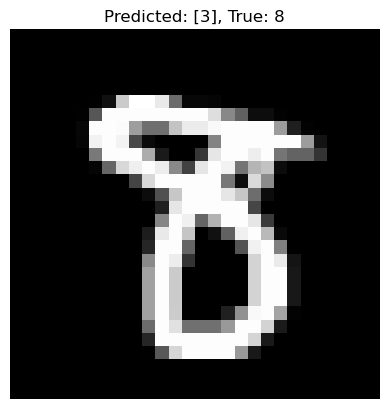

Misclassified index 4861: Predicted [3], True 7


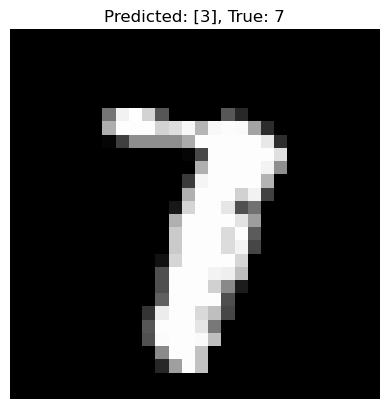

Misclassified index 4880: Predicted [8], True 0


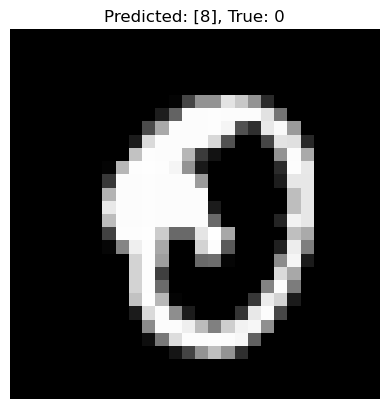

Misclassified index 4886: Predicted [1], True 7


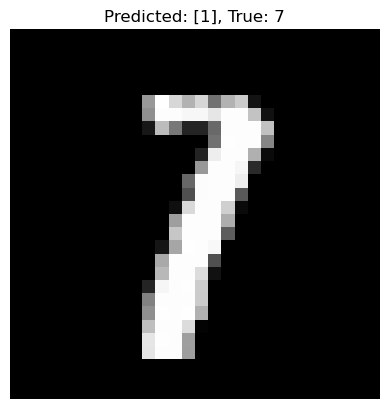

Misclassified index 4890: Predicted [6], True 8


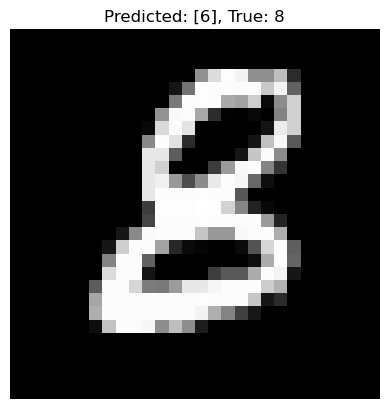

Misclassified index 4956: Predicted [4], True 8


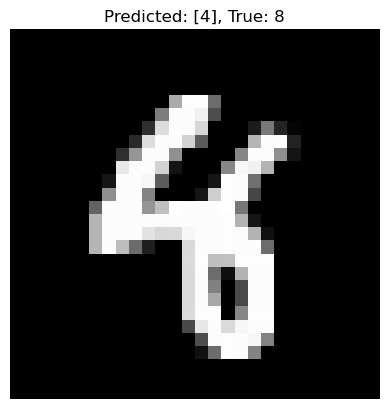

Misclassified index 4966: Predicted [1], True 7


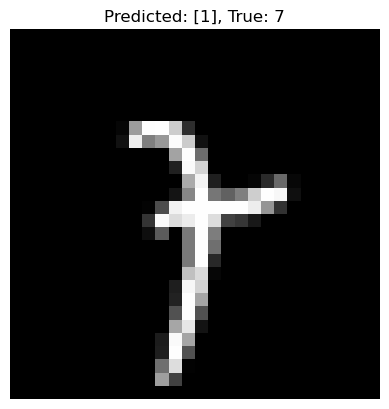

Misclassified index 4990: Predicted [2], True 3


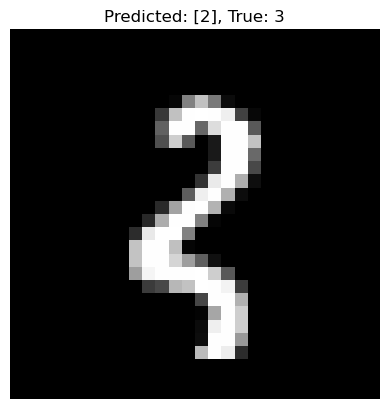

Misclassified index 5140: Predicted [6], True 3


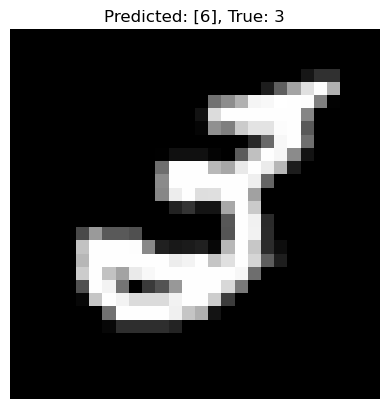

Misclassified index 5165: Predicted [5], True 0


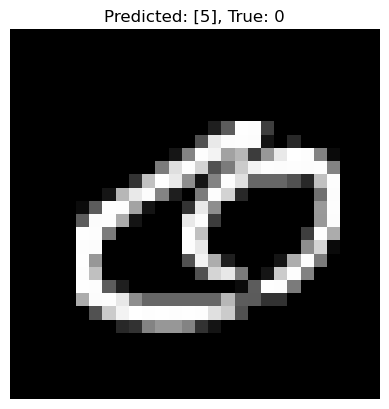

Misclassified index 5194: Predicted [9], True 5


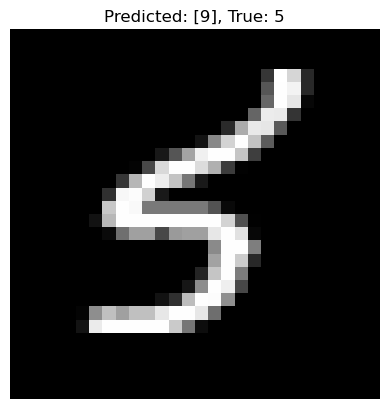

Misclassified index 5331: Predicted [6], True 1


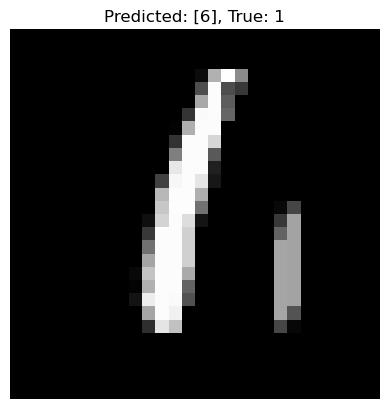

Misclassified index 5457: Predicted [8], True 1


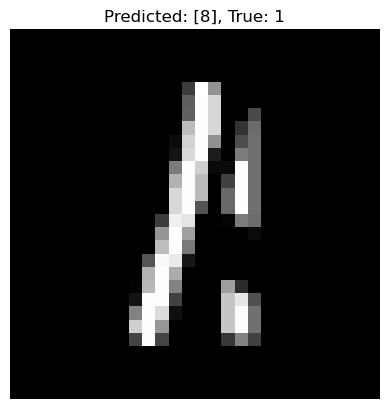

Misclassified index 5495: Predicted [3], True 8


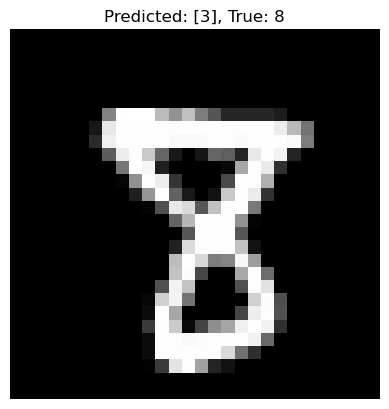

Misclassified index 5600: Predicted [9], True 7


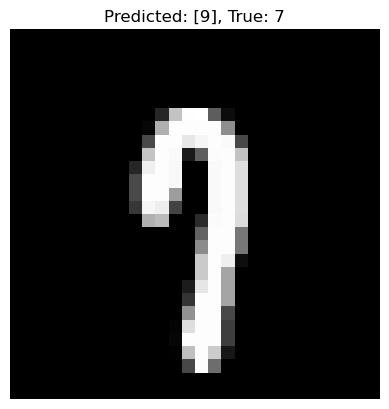

Misclassified index 5642: Predicted [8], True 1


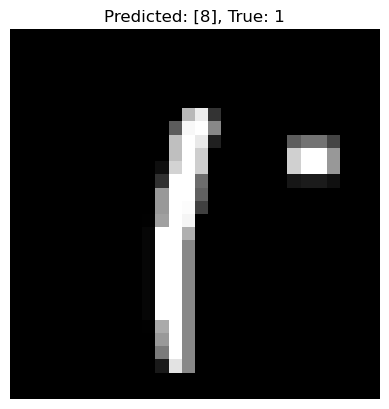

Misclassified index 5734: Predicted [9], True 3


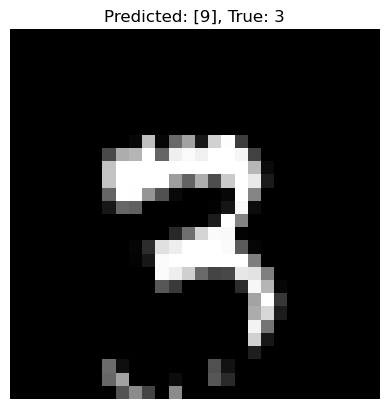

Misclassified index 5735: Predicted [3], True 5


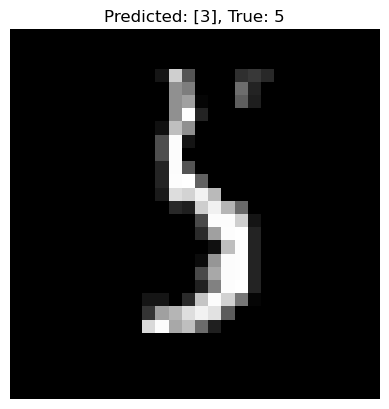

Misclassified index 5749: Predicted [2], True 8


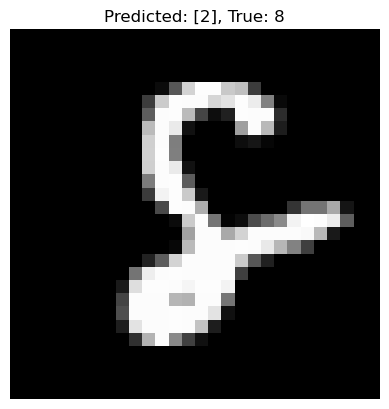

Misclassified index 5835: Predicted [9], True 7


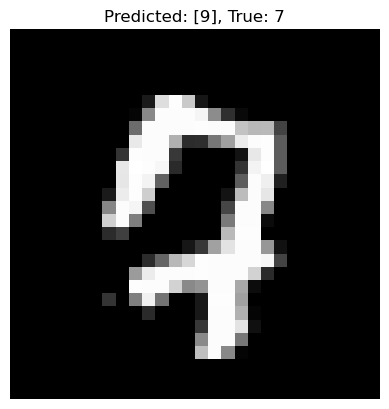

Misclassified index 5842: Predicted [9], True 4


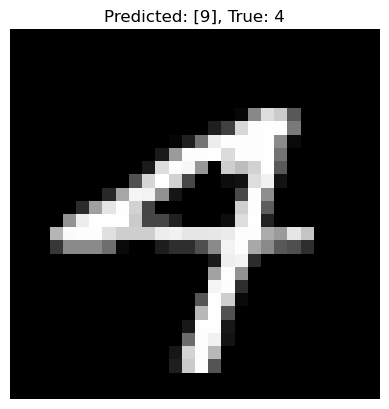

Misclassified index 5854: Predicted [4], True 7


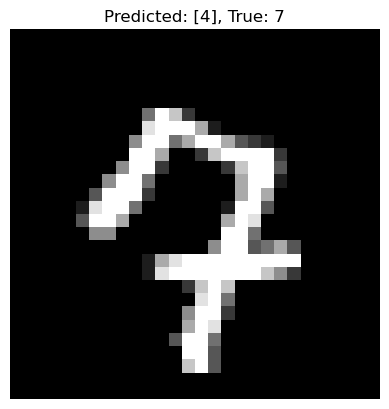

Misclassified index 5887: Predicted [9], True 7


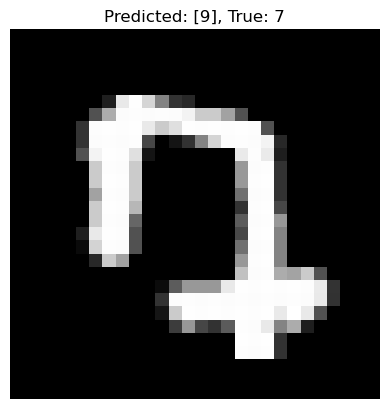

Misclassified index 5906: Predicted [9], True 7


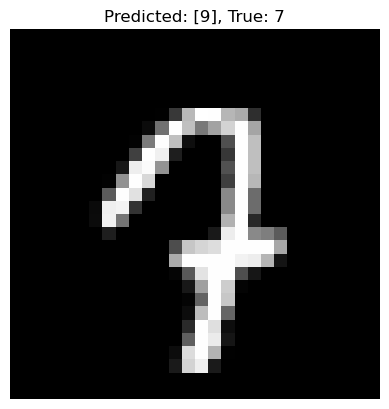

Misclassified index 5936: Predicted [9], True 4


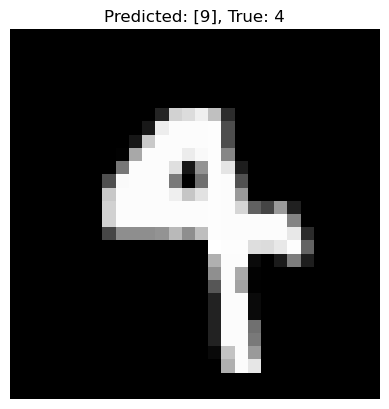

Misclassified index 5937: Predicted [3], True 5


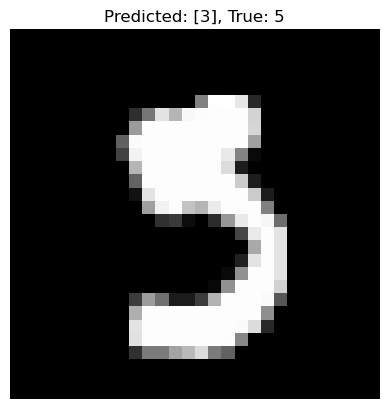

Misclassified index 5955: Predicted [8], True 3


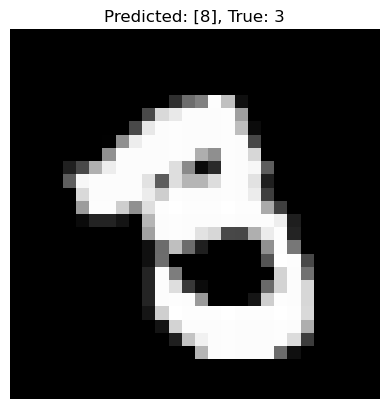

Misclassified index 5972: Predicted [3], True 5


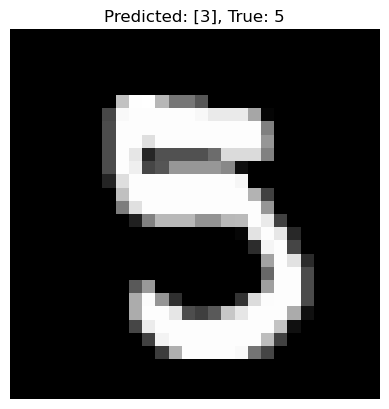

Misclassified index 5973: Predicted [8], True 3


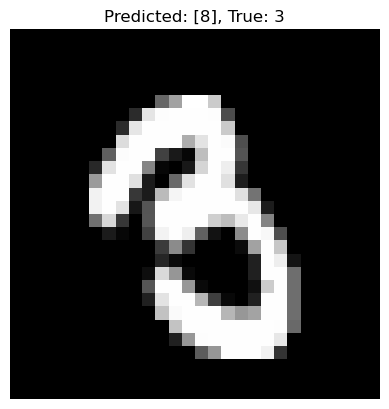

Misclassified index 6024: Predicted [3], True 8


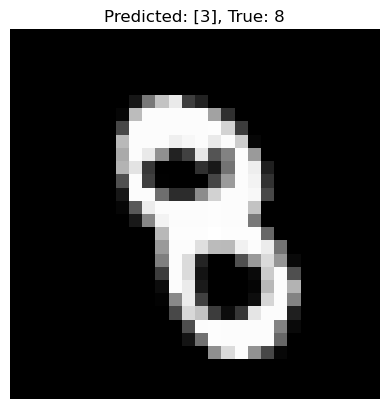

Misclassified index 6059: Predicted [8], True 3


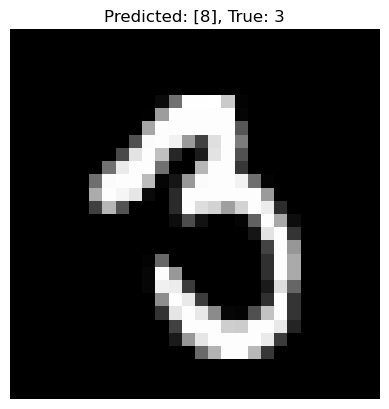

Misclassified index 6071: Predicted [3], True 9


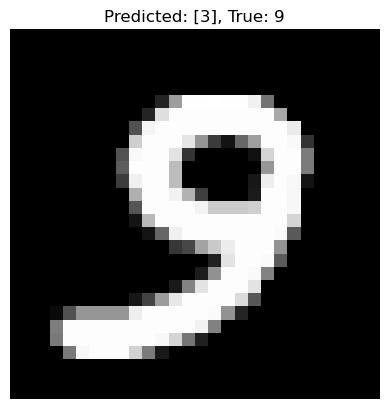

Misclassified index 6166: Predicted [3], True 9


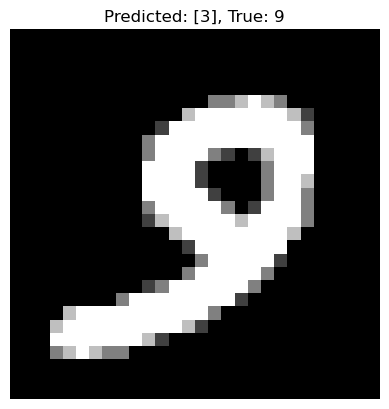

Misclassified index 6173: Predicted [2], True 9


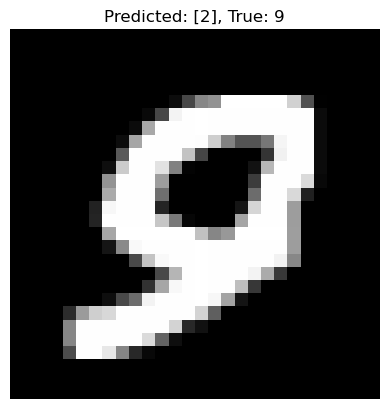

Misclassified index 6347: Predicted [6], True 8


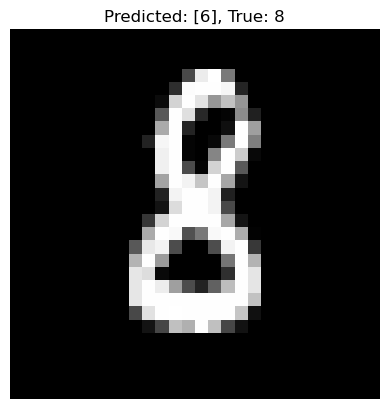

Misclassified index 6390: Predicted [8], True 5


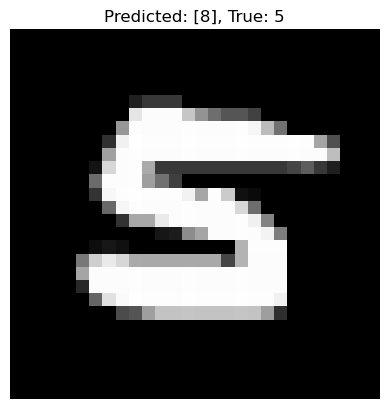

Misclassified index 6494: Predicted [5], True 3


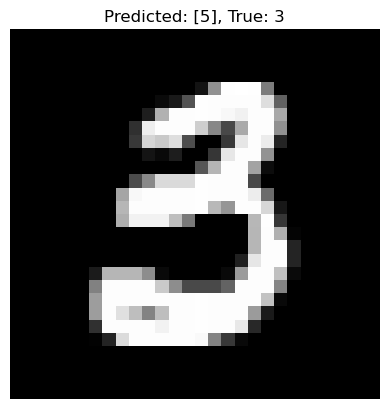

Misclassified index 6511: Predicted [5], True 3


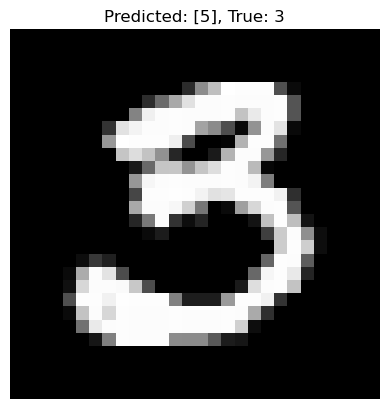

Misclassified index 6555: Predicted [9], True 8


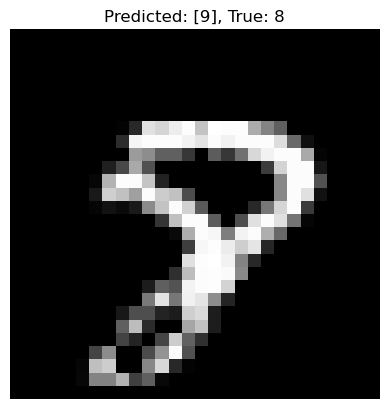

Misclassified index 6560: Predicted [8], True 9


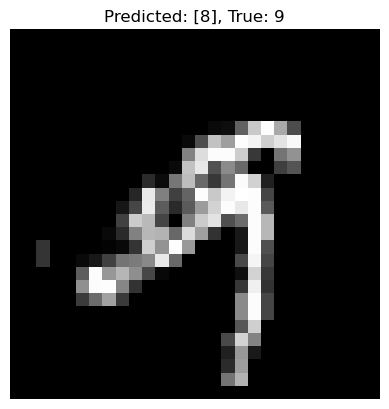

Misclassified index 6568: Predicted [4], True 9


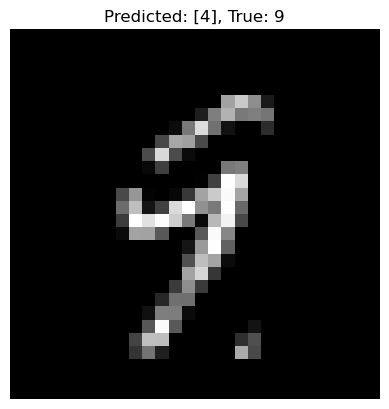

Misclassified index 6571: Predicted [7], True 9


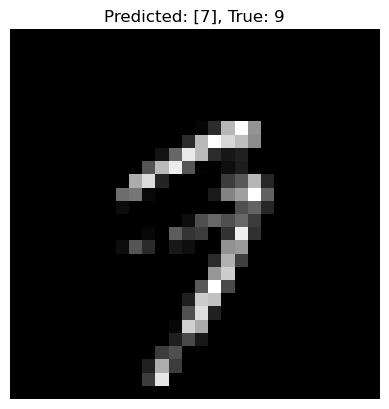

Misclassified index 6576: Predicted [1], True 7


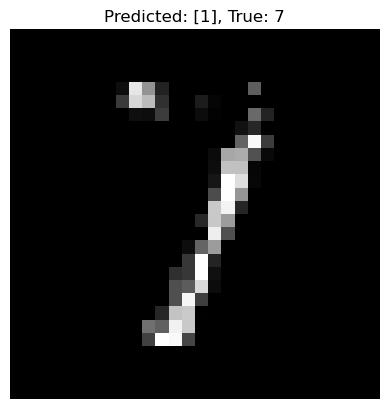

Misclassified index 6597: Predicted [7], True 0


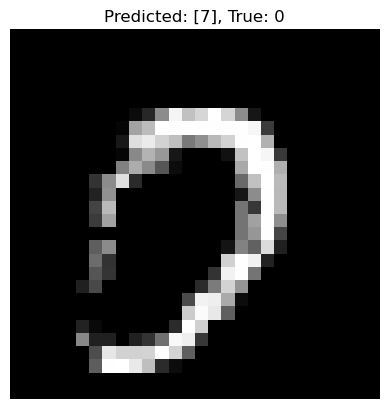

Misclassified index 6625: Predicted [4], True 8


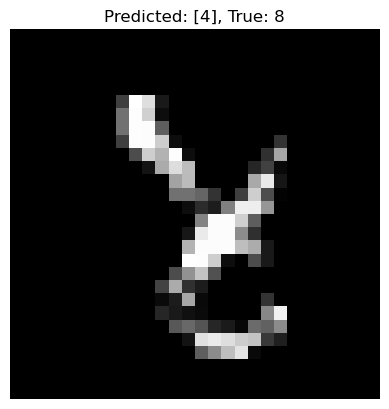

Misclassified index 6651: Predicted [4], True 0


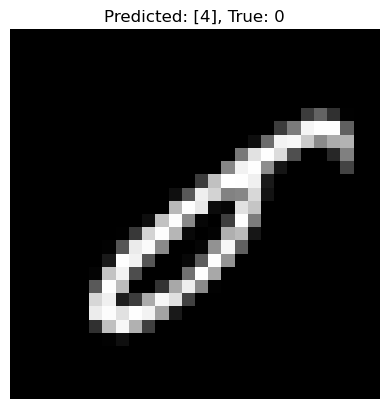

Misclassified index 6662: Predicted [3], True 7


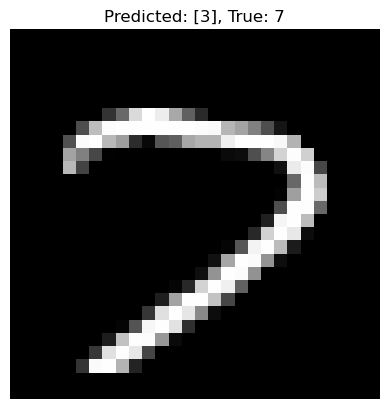

Misclassified index 6755: Predicted [3], True 8


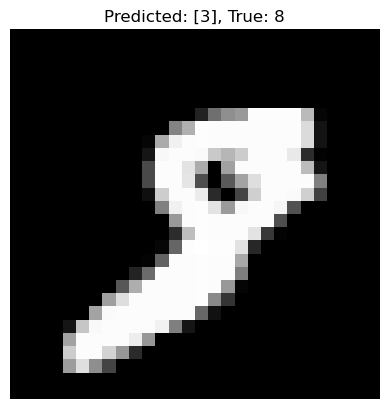

Misclassified index 6783: Predicted [6], True 1


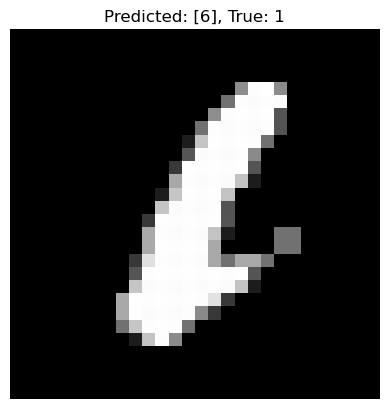

Misclassified index 6926: Predicted [4], True 6


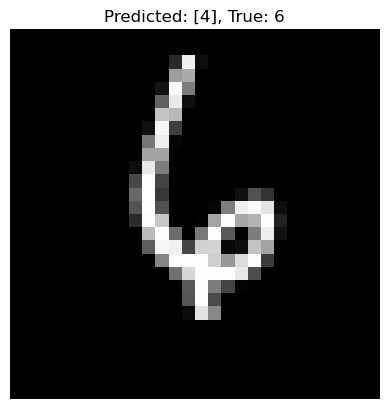

Misclassified index 7216: Predicted [3], True 0


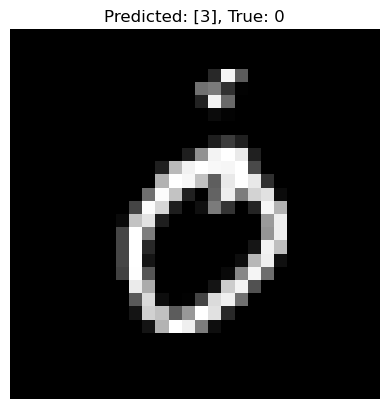

Misclassified index 7268: Predicted [4], True 7


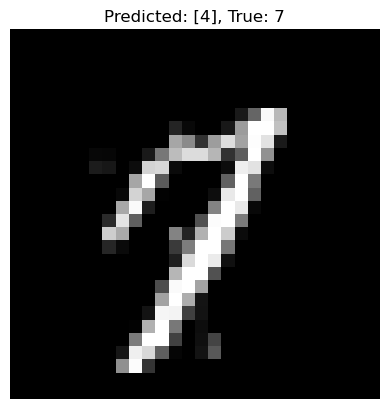

Misclassified index 7432: Predicted [1], True 7


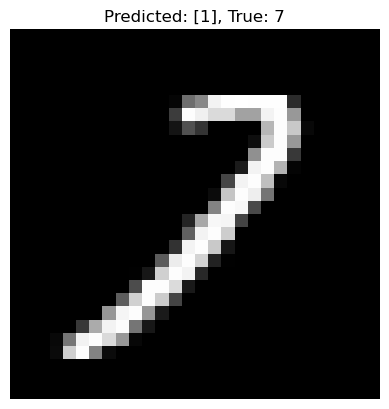

Misclassified index 7434: Predicted [8], True 4


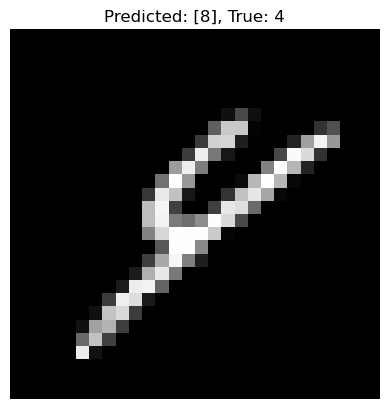

Misclassified index 7451: Predicted [6], True 5


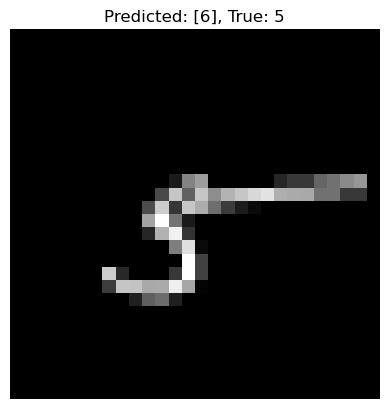

Misclassified index 7511: Predicted [3], True 5


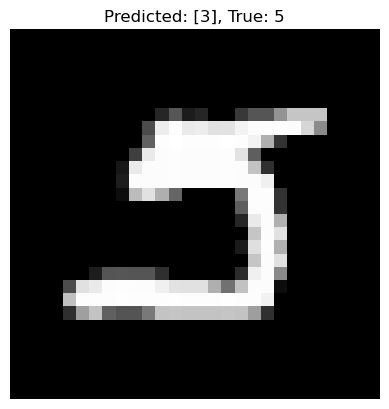

Misclassified index 7545: Predicted [9], True 8


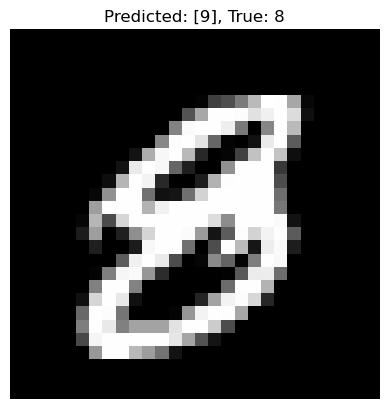

Misclassified index 7797: Predicted [6], True 5


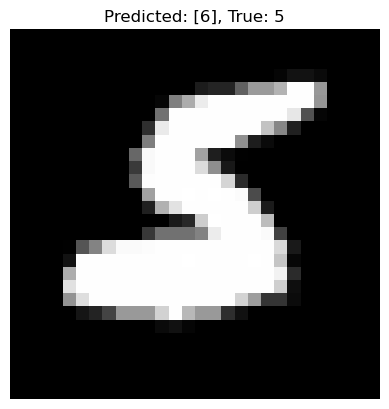

Misclassified index 7823: Predicted [2], True 8


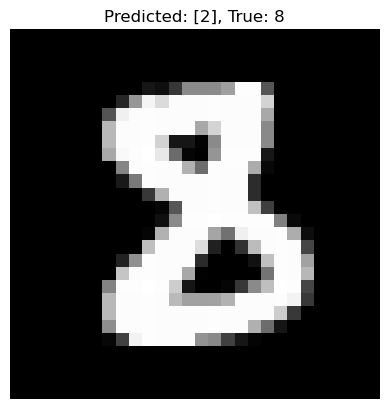

Misclassified index 7876: Predicted [4], True 2


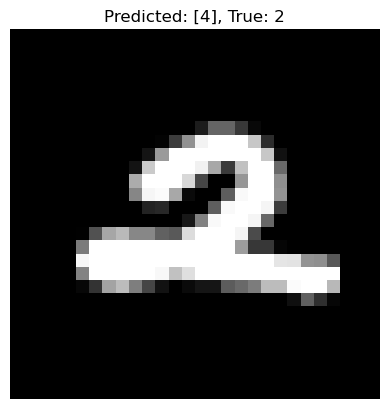

Misclassified index 7899: Predicted [8], True 1


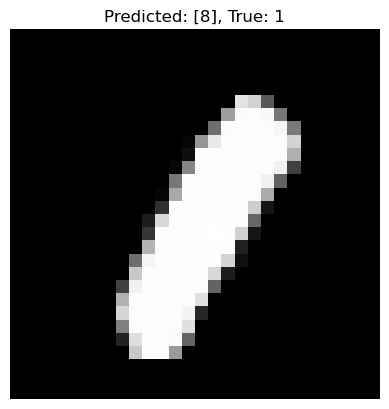

Misclassified index 7918: Predicted [6], True 5


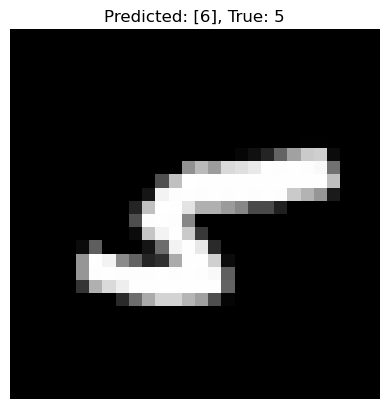

Misclassified index 7990: Predicted [8], True 1


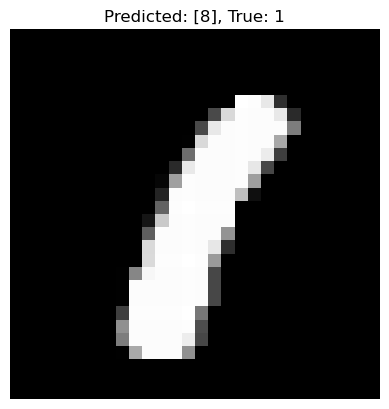

Misclassified index 7991: Predicted [8], True 9


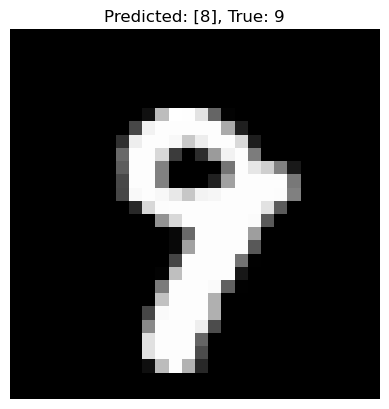

Misclassified index 8020: Predicted [8], True 1


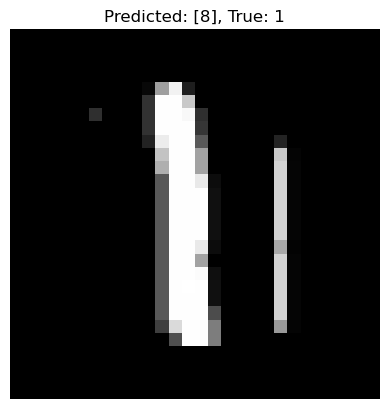

Misclassified index 8062: Predicted [8], True 5


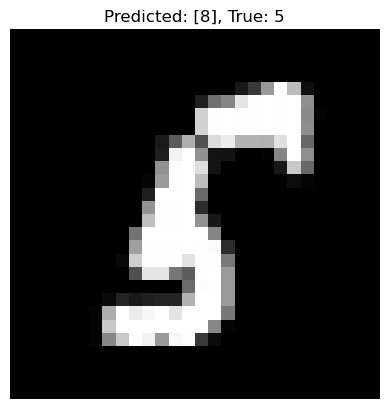

Misclassified index 8094: Predicted [8], True 2


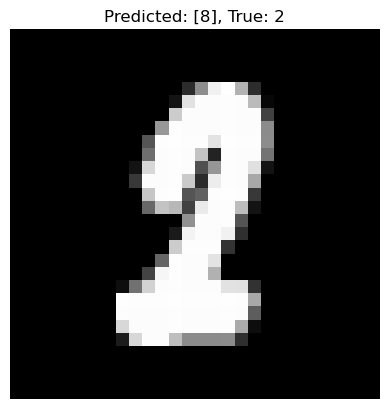

Misclassified index 8095: Predicted [6], True 4


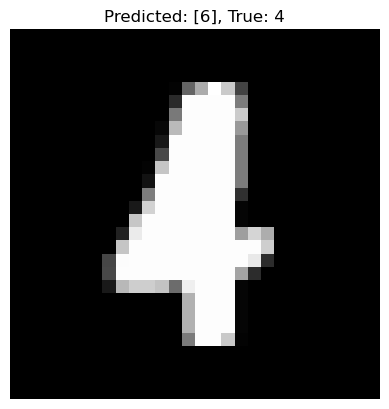

Misclassified index 8143: Predicted [4], True 6


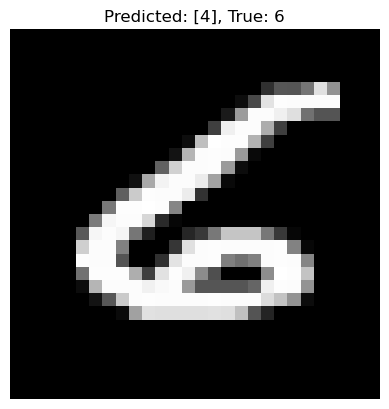

Misclassified index 8183: Predicted [5], True 8


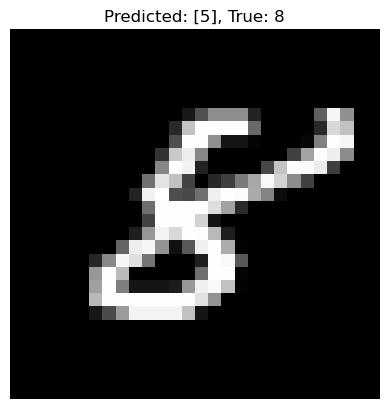

Misclassified index 8272: Predicted [5], True 3


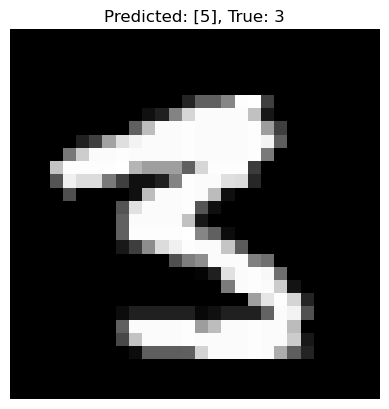

Misclassified index 8277: Predicted [9], True 3


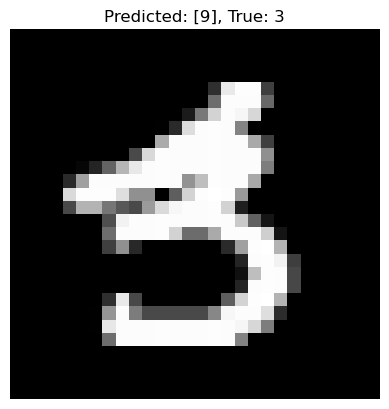

Misclassified index 8279: Predicted [4], True 8


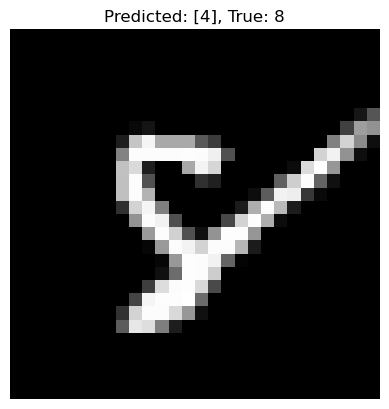

Misclassified index 8304: Predicted [3], True 7


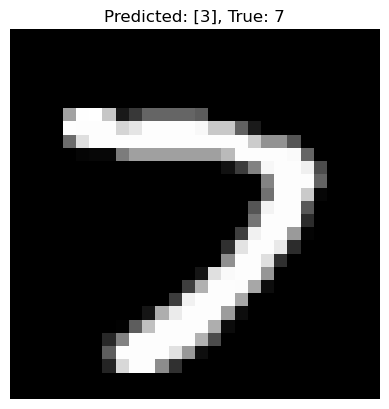

Misclassified index 8311: Predicted [4], True 6


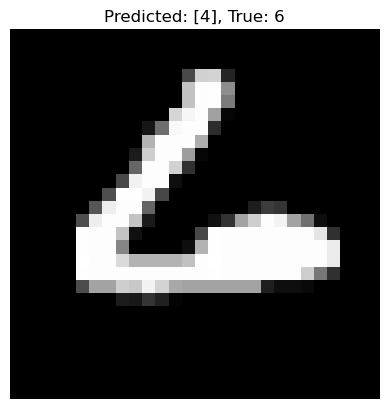

Misclassified index 8316: Predicted [2], True 7


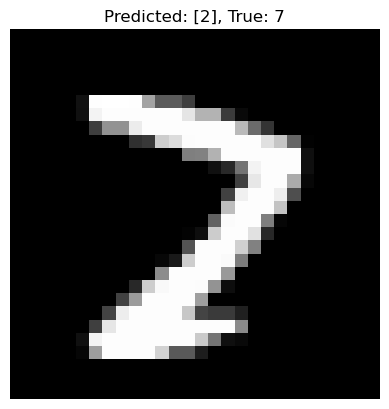

Misclassified index 8318: Predicted [0], True 2


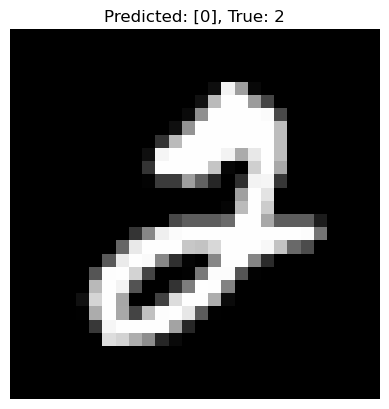

Misclassified index 8325: Predicted [6], True 0


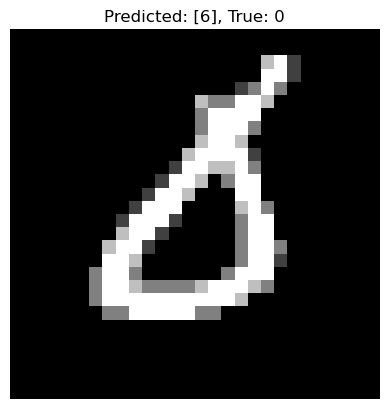

Misclassified index 8339: Predicted [6], True 8


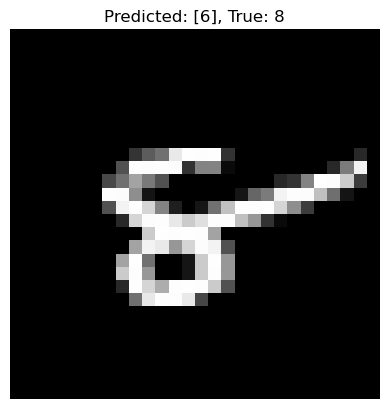

Misclassified index 8406: Predicted [9], True 4


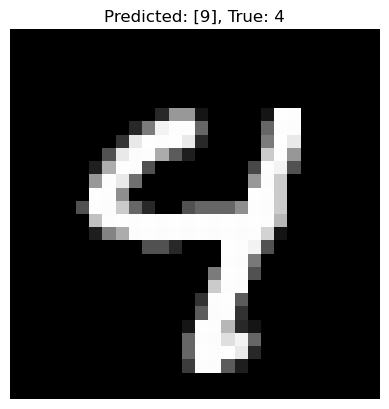

Misclassified index 8408: Predicted [6], True 8


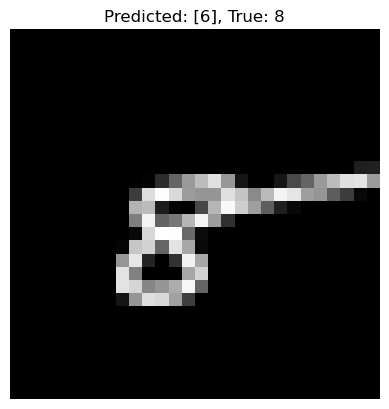

Misclassified index 8410: Predicted [6], True 8


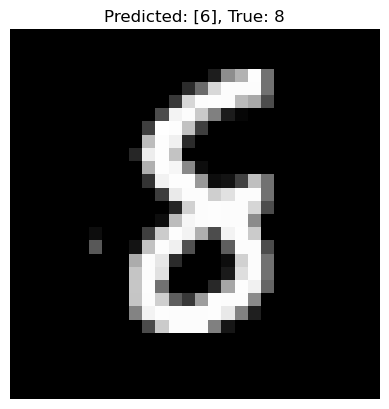

Misclassified index 8519: Predicted [3], True 7


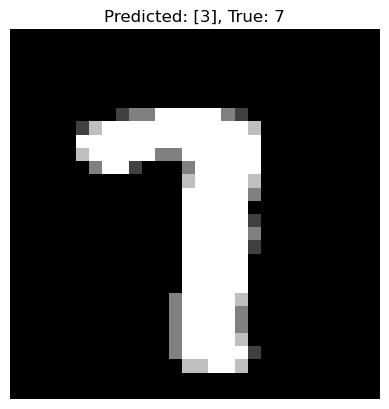

Misclassified index 8520: Predicted [9], True 4


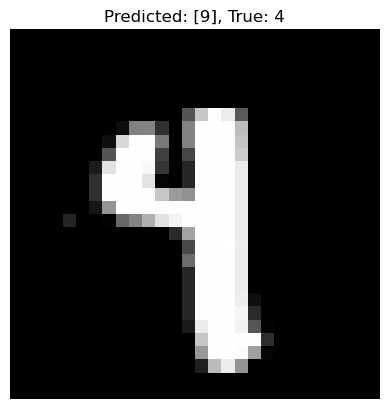

Misclassified index 8522: Predicted [6], True 8


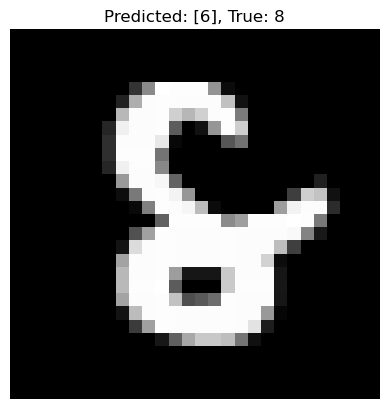

Misclassified index 8527: Predicted [9], True 4


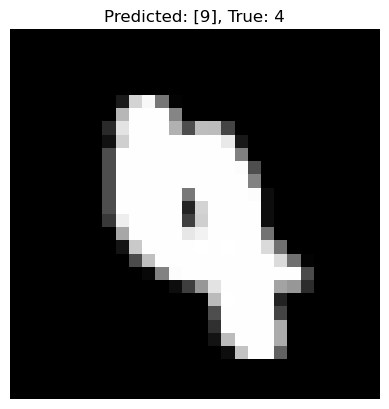

Misclassified index 9009: Predicted [2], True 7


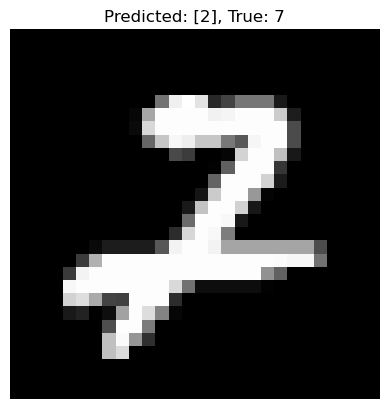

Misclassified index 9015: Predicted [2], True 7


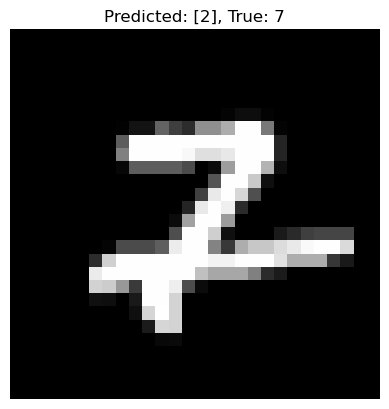

Misclassified index 9019: Predicted [2], True 7


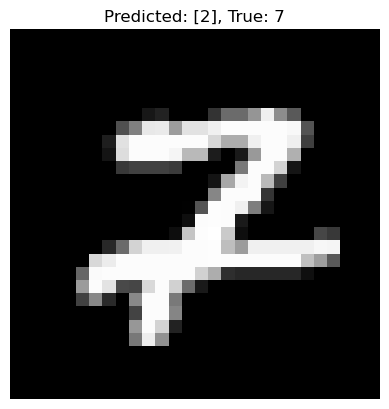

Misclassified index 9024: Predicted [2], True 7


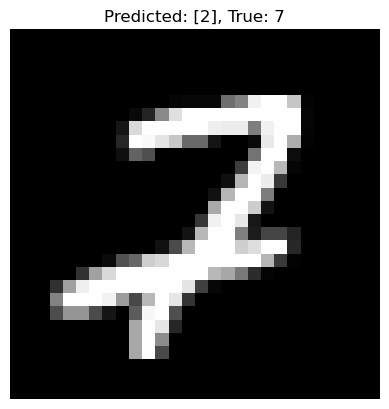

Misclassified index 9036: Predicted [2], True 7


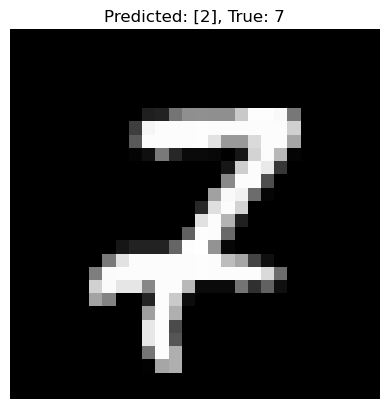

Misclassified index 9045: Predicted [2], True 7


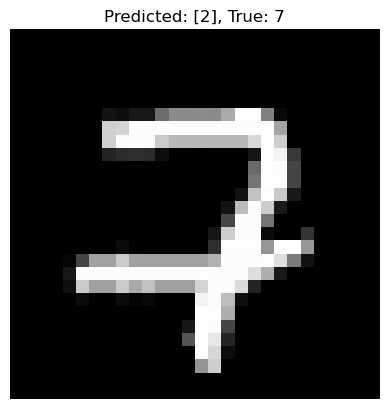

Misclassified index 9280: Predicted [5], True 8


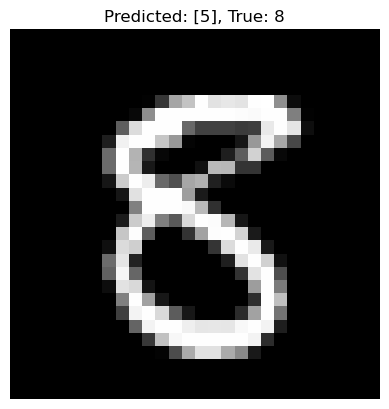

Misclassified index 9422: Predicted [3], True 5


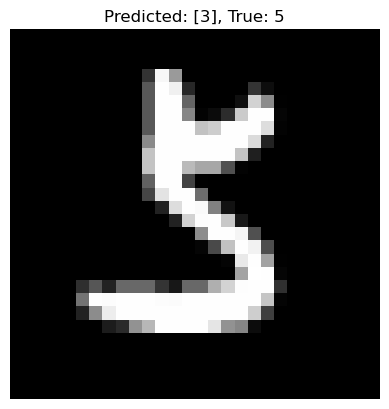

Misclassified index 9482: Predicted [3], True 5


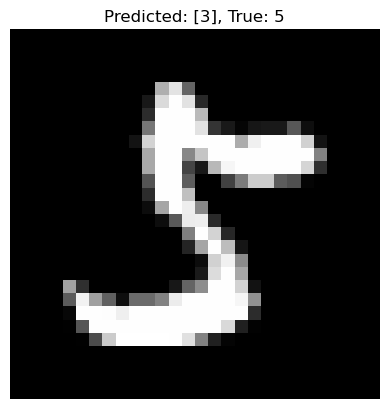

Misclassified index 9534: Predicted [9], True 7


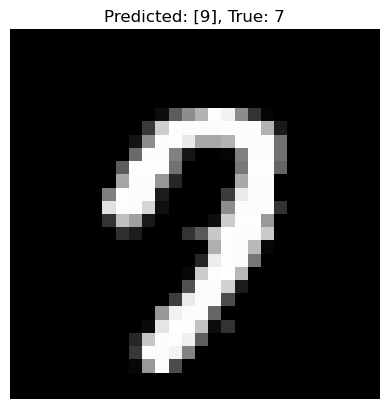

Misclassified index 9587: Predicted [4], True 9


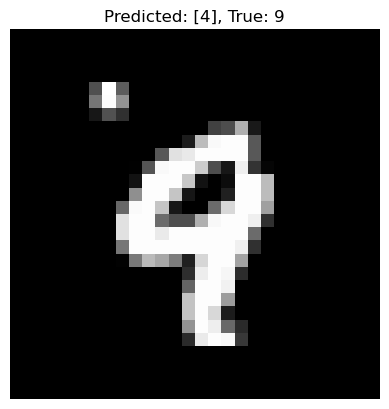

Misclassified index 9634: Predicted [3], True 0


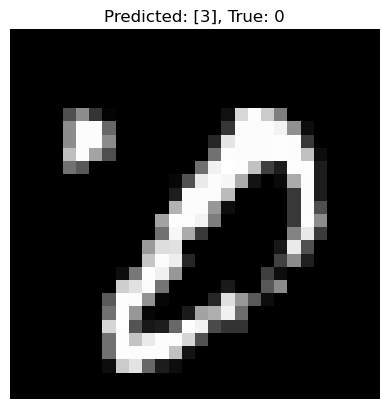

Misclassified index 9664: Predicted [7], True 2


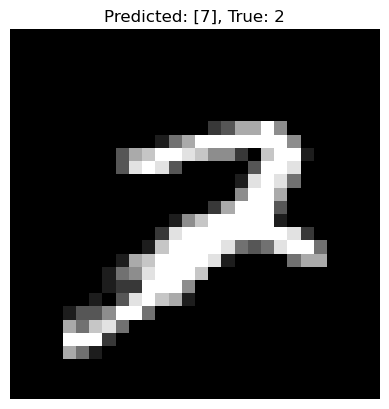

Misclassified index 9679: Predicted [3], True 6


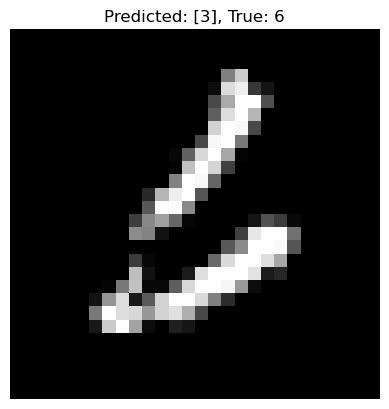

Misclassified index 9695: Predicted [3], True 8


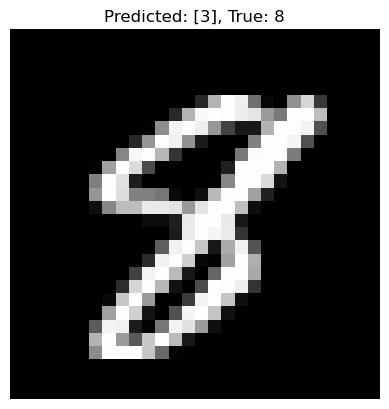

Misclassified index 9729: Predicted [6], True 5


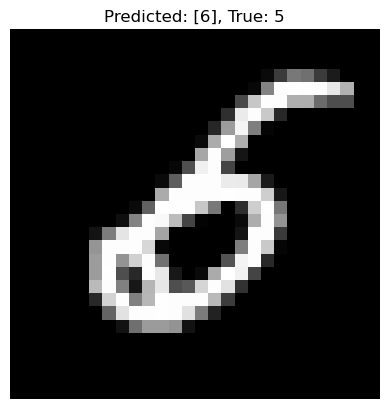

Misclassified index 9745: Predicted [6], True 4


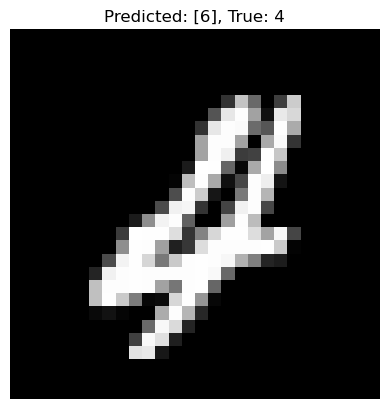

Misclassified index 9749: Predicted [6], True 5


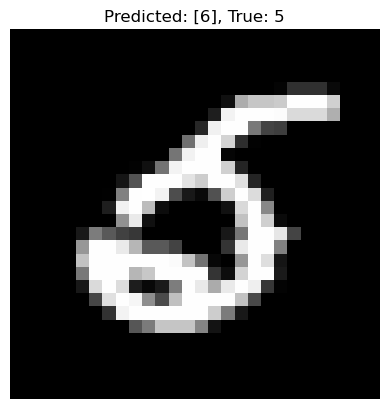

Misclassified index 9755: Predicted [5], True 8


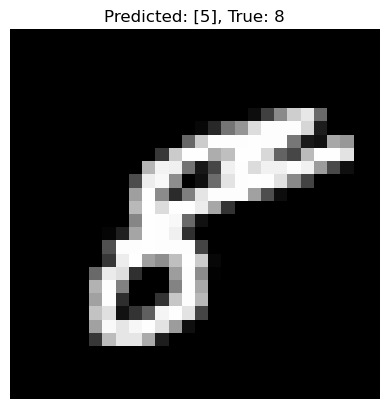

Misclassified index 9768: Predicted [0], True 2


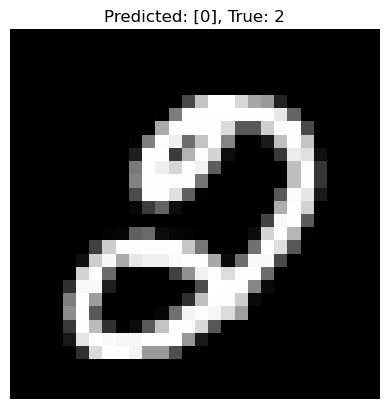

Misclassified index 9770: Predicted [0], True 5


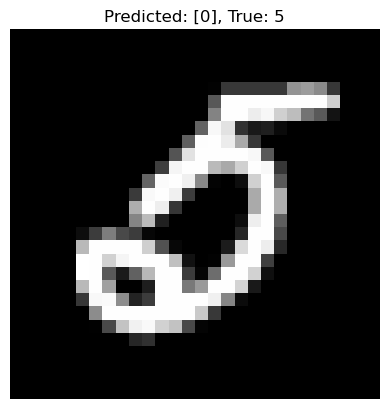

Misclassified index 9777: Predicted [0], True 5


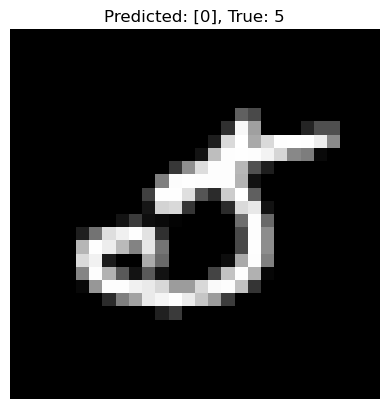

Misclassified index 9779: Predicted [0], True 2


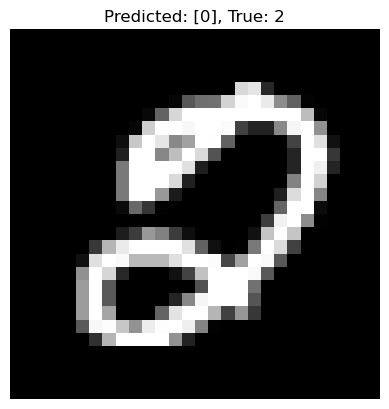

Misclassified index 9792: Predicted [7], True 4


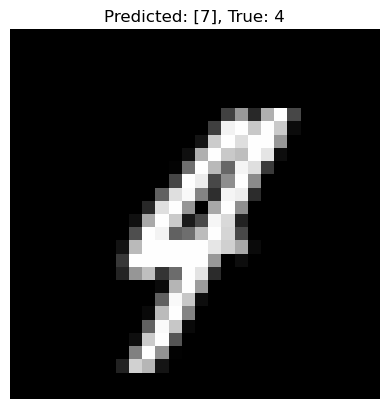

Misclassified index 9808: Predicted [4], True 9


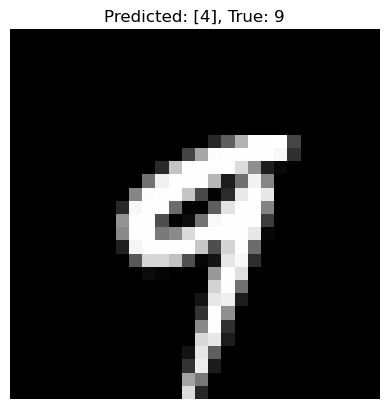

Misclassified index 9811: Predicted [8], True 2


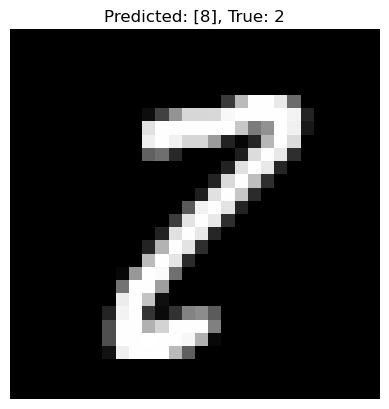

Misclassified index 9839: Predicted [3], True 2


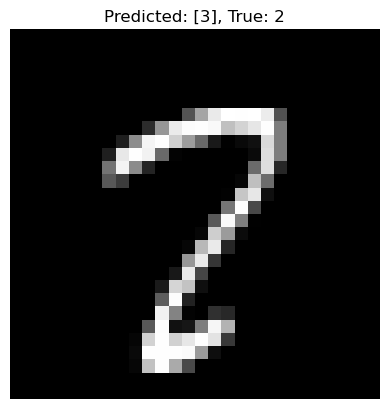

Misclassified index 9858: Predicted [8], True 6


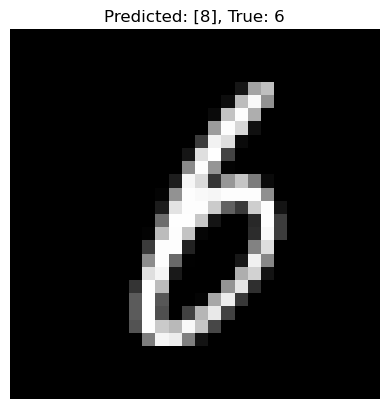

Misclassified index 9879: Predicted [2], True 0


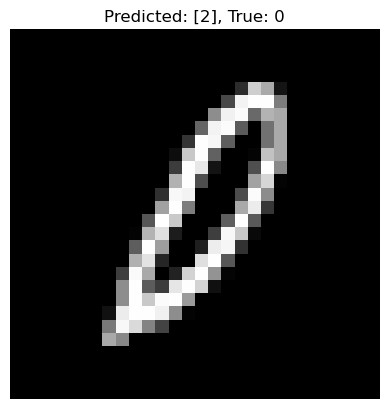

Misclassified index 9916: Predicted [9], True 7


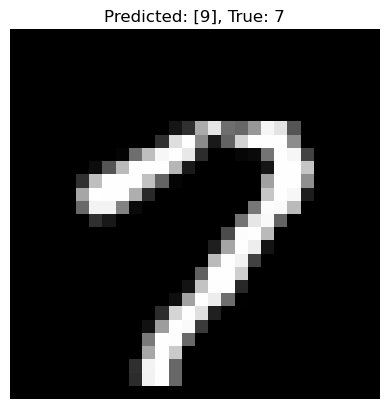

Misclassified index 9925: Predicted [8], True 3


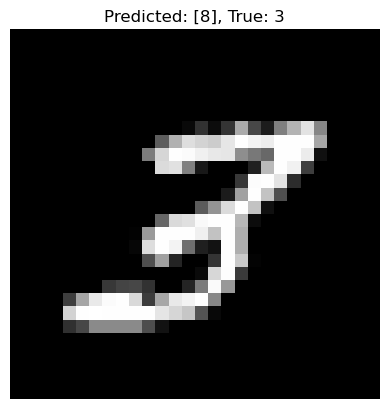

Misclassified index 9944: Predicted [8], True 3


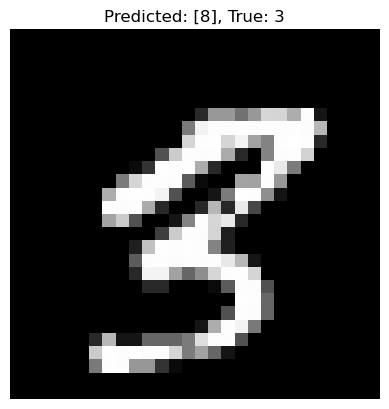

Misclassified index 9982: Predicted [6], True 5


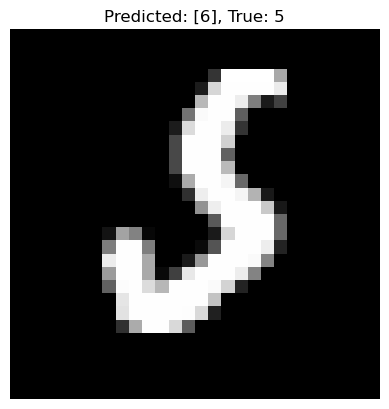

In [80]:
for i in range(len(images)):
    if all_preds[i] != all_targets[i]:
        print(f"Misclassified index {i}: Predicted {all_preds[i]}, True {all_targets[i]}")
        show_prediction(i)
        #break  # 或者收集多个错误样本
